**Table of Contents** <br>
* [1. Import](#import)
    * [1.1. Import Libraries](#importlibraries)
    * [1.2. Import Datasets](#importdatasets)
* [2. Data Preparation](#datapreparation)
    * [2.1.Descriptive Statistics ](#descripstat)
    * [2.2.Coherence Checking](#coherencechecking)
    * [2.3. Missing Values](#missval)
    * [2.4. Outlier Removal](#outlierremoval)
      * [2.4.1. Manual](#manual)
      * [2.4.2. IQR](#iqr)
      * [2.4.3 Manual + IQR ](#manual+iqr)
      * [2.4.4. Z-Score](#z-score)
      * [2.4.5. DBSCAN](#dbscan_outliers)
* [3. Data Pre-Processing](#datapreprocessing)
   * [3.1. Dimensionalty Reduction](#dimreduct)
     * [3.1.1. Redundancy](#redundancy)
     * [3.1.2. Relevancy](#relevancy)
* [4. Data Analysis](#analysis)
* [5. Feature Scalling](#featurescalling)
* [6. Clustering Methods](#clustmeth)
    * [6.1. K-Means + Hierarchical Clustering](#k-means+hc)
    * [6.2. Self Organizing Maps + Hierarchical](#som+hc)
    * [6.3. Self Organizing Maps + K-Means](#som+k-means)
    * [6.4. Mean Shift Clustering](#meanshiftclust)
    * [6.5. DBSCAN](#dbscan)
    * [6.6. BIRCH](#birch)
    * [6.7 OPTICS](#optics)
* [7.Clustering Methods Comparison](#clustmetcomp)
* [8. Merging the Perspectives](#mergpersp) 
* [9. Cluster Visualization using t-SNE](#t-sne) 
* [10. Assess feature importance](#featimp) 
* [11.Reclassify Outliers](#reoutliers)
* [12. Final Clustering Analysis](#finalanalysis)

<hr>
<a class="anchor" id="import">
    
# 1. Imports
    
</a>

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [2]:
import sqlite3
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas_profiling import ProfileReport

import statsmodels.api as sm
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth, Birch, OPTICS
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [170]:
%matplotlib inline

<a class="anchor" id="importdataset">

## 1.2. Import Dataset

</a>

In [11]:
path = 'https://raw.githubusercontent.com/SaraxSilva/Business-Cases-Projects-21-22/main/BC1_customer_segmentation/'
www = pd.read_excel(path + 'WonderfulWinesoftheWorld.xlsx',sheet_name='wwwdata1')



www.head()

Custid  Dayswus   Age   Edu    Income  Freq  Recency  Monetary    LTV  \
0  5325.0    653.0  55.0  20.0   78473.0  20.0     18.0     826.0  445.0   
1  3956.0   1041.0  75.0  18.0  105087.0  36.0     33.0    1852.0  539.0   
2  3681.0    666.0  18.0  12.0   27984.0   4.0     56.0      39.0   -7.0   
3  2829.0   1049.0  42.0  16.0   61748.0   2.0     46.0      37.0   -6.0   
4  8788.0    837.0  47.0  16.0   65789.0   2.0      3.0      36.0    4.0   

   Perdeal  Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  WebPurchase  \
0      7.0    67.0       4.0   26.0      2.0      1.0     1.0         36.0   
1      2.0    49.0       0.0   46.0      1.0      3.0     0.0         20.0   
2     88.0     4.0      29.0   14.0     32.0     21.0    48.0         60.0   
3     70.0    86.0       1.0   11.0      1.0      1.0    55.0         59.0   
4     35.0    85.0       0.0   12.0      2.0      1.0    28.0         63.0   

   WebVisit  
0       5.0  
1       4.0  
2       8.0  
3       7.0  
4       6.0

In [172]:
www.shape[0]

10001

<hr>
<a class="anchor" id="datapreparation">
    
# 2. Data Preparation
    
</a>

### Explore Datatypes


In [173]:
www.dtypes

Custid         float64
Dayswus        float64
Age            float64
Edu            float64
Income         float64
Freq           float64
Recency        float64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
dtype: object

In [174]:
www.tail(1)

Custid  Dayswus      Age      Edu     Income     Freq  Recency  \
10000     NaN  898.102  47.9273  16.7391  69904.358  14.6281  62.4068   

       Monetary       LTV  Perdeal   Dryred  Sweetred    Drywh  Sweetwh  \
10000  622.5552  209.0712  32.3972  50.3827    7.0545  28.5213   7.0698   

       Dessert   Exotic  WebPurchase  WebVisit  
10000   6.9474  16.5466      42.3762    5.2166

In [175]:
www.drop(10000, axis=0, inplace=True)

In [176]:
# fix wrong dtypes
columns = ['Custid', 'Dayswus', 'Age', 'Edu', 'Freq', 'Recency']

for column in columns:
    www[column] = www[column].astype('int64')

In [177]:
# set the new index
www.set_index('Custid', inplace = True)
www.dtypes

Dayswus          int64
Age              int64
Edu              int64
Income         float64
Freq             int64
Recency          int64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
dtype: object

### Check Duplicates

In [178]:
www.duplicated().sum() 

0

<a class="anchor" id="descripstat">

## 2.1. Descriptive Statistics

</a>

In [179]:
www.describe().T

count        mean           std      min       25%      50%  \
Dayswus      10000.0    898.1020    202.492789    550.0    723.75    894.0   
Age          10000.0     47.9273     17.302721     18.0     33.00     48.0   
Edu          10000.0     16.7391      1.876375     12.0     15.00     17.0   
Income       10000.0  69904.3580  27612.233311  10000.0  47642.00  70012.0   
Freq         10000.0     14.6281     11.969073      1.0      4.00     12.0   
Recency      10000.0     62.4068     69.874255      0.0     26.00     52.0   
Monetary     10000.0    622.5552    647.135323      6.0     63.00    383.0   
LTV          10000.0    209.0712    291.986040   -178.0     -2.00     57.0   
Perdeal      10000.0     32.3972     27.897094      0.0      6.00     25.0   
Dryred       10000.0     50.3827     23.453815      1.0     32.00     51.0   
Sweetred     10000.0      7.0545      7.866544      0.0      2.00      4.0   
Drywh        10000.0     28.5213     12.583957      1.0     19.00     28.0   
Sweetwh      10000.0      7.0698      8.015083      0.0      2.00      4.0   
Dessert      10000.0      6.9474      7.879546      0.0      2.00      4.0   
Exotic       10000.0     16.5466     17.247672      0.0      4.00     10.0   
WebPurchase  10000.0     42.3762     18.522062      4.0     28.00     45.0   
WebVisit     10000.0      5.2166      2.330457      0.0      3.00      6.0   

                  75%       max  
Dayswus       1074.00    1250.0  
Age             63.00      78.0  
Edu             18.00      20.0  
Income       92147.00  140628.0  
Freq            24.00      56.0  
Recency         78.25     549.0  
Monetary      1077.00    3052.0  
LTV            364.00    1791.0  
Perdeal         56.00      97.0  
Dryred          69.00      99.0  
Sweetred        10.00      75.0  
Drywh           37.00      74.0  
Sweetwh         10.00      62.0  
Dessert          9.00      77.0  
Exotic          23.00      96.0  
WebPurchase     57.00      88.0  
WebVisit         7.00      10.0

<hr>
<a class="anchor" id="coherencechecking">
    
## 2.2. Coherence Checking
    
</a>

In [180]:
# age - edu < 5
www.loc[www['Age'] - www['Edu'] < 5]

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []

<a class="anchor" id="missval">

## 2.3. Missing Values

</a>

In [181]:
## Count missing values
www.isna().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

<hr>
<a class="anchor" id="outlierremoval">
    
# 2.4. Outlier Removal
    
</a>

### Data Visualization

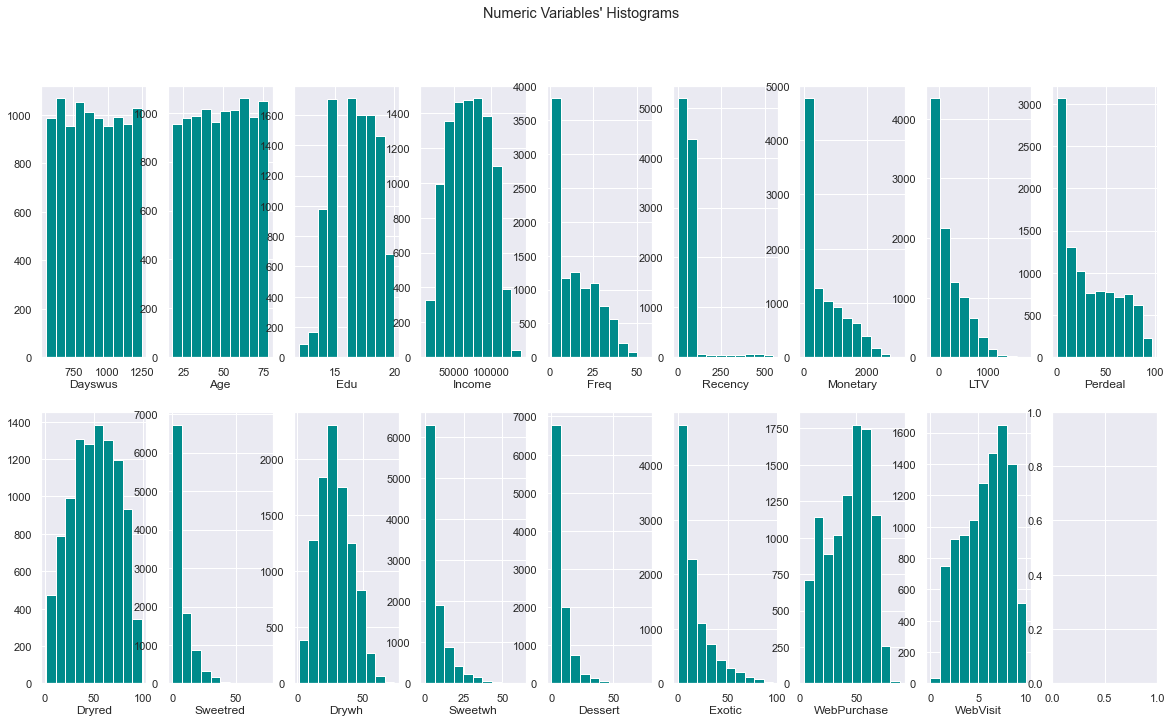

In [182]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(www.columns) / 2), figsize=(20, 11))


for ax, feat in zip(axes.flatten(), www.columns):
    ax.hist(www[feat], color = 'darkcyan')
    ax.set_title(feat, y=-0.13)
    

title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

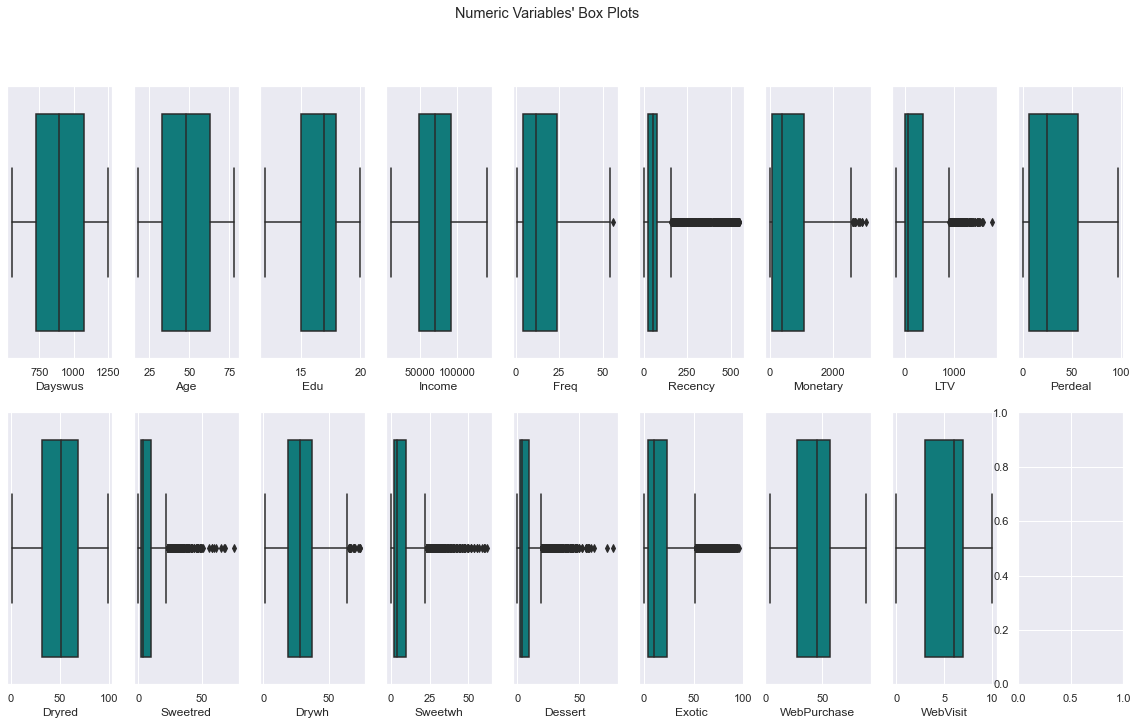

In [183]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(www.columns) / 2), figsize=(20, 11))


for ax, feat in zip(axes.flatten(), www.columns): 
    sns.boxplot(www[feat], ax=ax, color = 'darkcyan')
    
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

<hr>
<a class="anchor" id="manual">
    
### 2.4.1 Manual
    
</a>

In [184]:
www_manually = www.copy()

In [185]:
# By analyzing the above visualizations, establish filters for each variable

filters = (
    (www_manually['Sweetred'] <= 45)
    &
    (www_manually['Dessert'] <= 50)
    &
    (www_manually['Sweetwh'] <= 50) 
)

www_manually = www_manually[filters]

In [186]:
print('Percentage of data kept after removing outliers:', np.round(www_manually.shape[0] / www.shape[0], 4))

Percentage of data kept after removing outliers: 0.9946


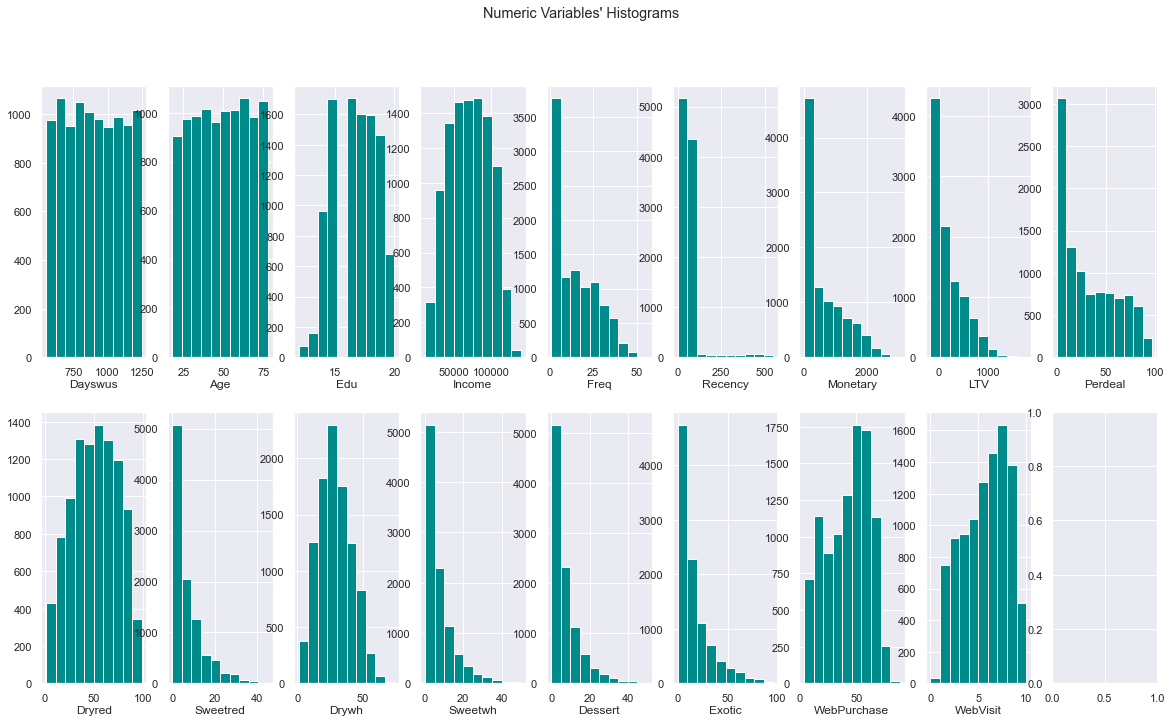

In [187]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(www.columns) / 2), figsize=(20, 11))


for ax, feat in zip(axes.flatten(), www.columns):
    ax.hist(www_manually[feat], color = 'darkcyan')
    ax.set_title(feat, y=-0.13)
    

title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

<hr>
<a class="anchor" id="iqr">
    
### 2.4.2. IQR
    
</a>

In [188]:
www_iqr = www.copy()

In [189]:
q25 = www_iqr.quantile(.25)
q75 = www_iqr.quantile(.75)
iqr = (q75 - q25)
# Establishing an upper and a lower limit, that will function as outliers borders

upper_lim = q75 + 7 * iqr
lower_lim = q25 - 7 * iqr

filters2 = []
for feat in www.columns:
    llim = lower_lim[feat]
    ulim = upper_lim[feat]
    filters2.append(www[feat].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0), index=www.index)

www_iqr = www_iqr[filters2]


print('Percentage of data kept after removing outliers:', np.round(www_iqr.shape[0] / www.shape[0], 4))

Percentage of data kept after removing outliers: 0.9885


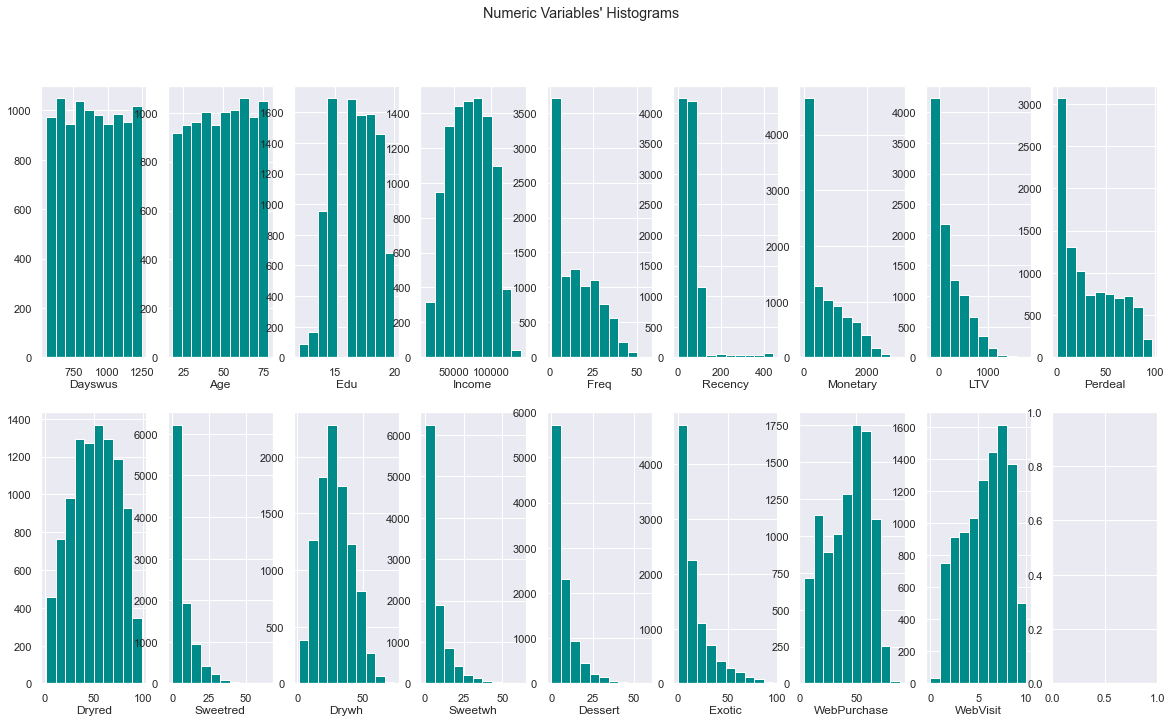

In [190]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(www.columns) / 2), figsize=(20, 11))


for ax, feat in zip(axes.flatten(), www.columns):
    ax.hist(www_iqr[feat], color = 'darkcyan')
    ax.set_title(feat, y=-0.13)
    

title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

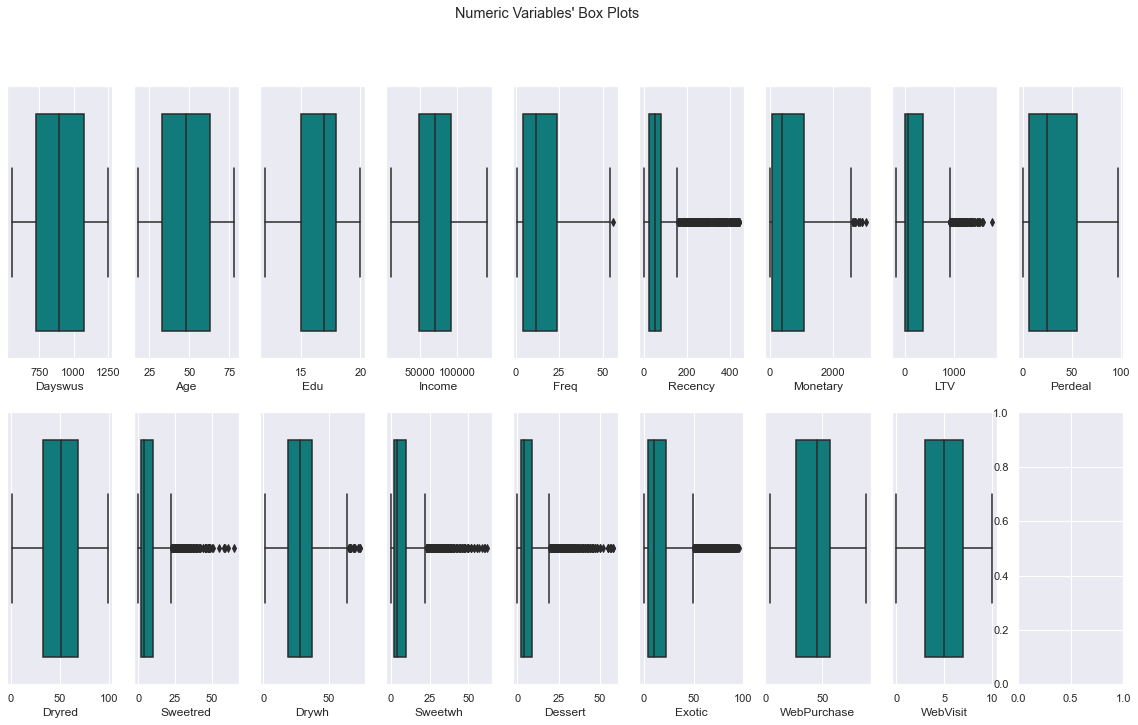

In [191]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(www.columns) / 2), figsize=(20, 11))


for ax, feat in zip(axes.flatten(), www.columns): 
    sns.boxplot(www_iqr[feat], ax=ax, color = 'darkcyan')
    
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

<hr>
<a class="anchor" id="manual&iqr">
    
### 2.4.3.  Manual & IQR

</a>

In [192]:
www_both = www[(filters | filters2)]
print('Percentage of data kept after removing outliers:', np.round(www_both.shape[0] / www.shape[0], 4))

Percentage of data kept after removing outliers: 0.9991


In [193]:
www_out = www_both[~(filters | filters2)]

<hr>
<a class="anchor" id="z-score">
    
### 2.4.4. Z-Score
    
</a>

In [194]:
z = np.abs(stats.zscore(www))

#only keep rows in dataframe with all z-scores less than absolute value of 4 
www_zscore = www[(z < 6).all(axis = 1)]

print('Percentage of train data kept after removing outliers:', np.round(www_zscore.shape[0] / www.shape[0], 4))

Percentage of train data kept after removing outliers: 0.9899


<hr>
<a class="anchor" id="dbscan_outliers">
    
### 2.4.5. DBSCAN
    
</a>

In [195]:
www_dbscan = www_both.copy()

In [196]:
# Scaled the data with MinMaxScaler() 
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(www_dbscan)

In [197]:
www_dbscan = pd.DataFrame(scaled_feat, columns = www_both.columns, index=www_both.index)

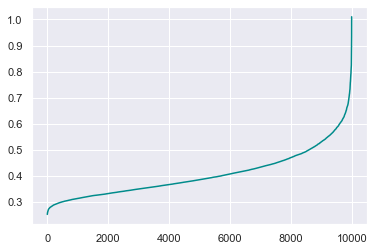

In [198]:
# Create the K-distance graph to find out
# the rigth epsilon value to work with
neigh = NearestNeighbors(n_neighbors = (2 * len(www.columns)) - 1)
neigh_fit = neigh.fit(www_dbscan)
distances, indices = neigh_fit.kneighbors(www_dbscan)
distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances, color = 'darkcyan')
plt.show()

In [199]:
# Perform DBSCAN clustering, after analysing the previous graphs
# with an epsilon of 0.55 (elbow) , and a min_samples equivalent to double 
# of the total number of metric features that we have
dbscan = DBSCAN(eps=0.55, min_samples = 2 * len(www.columns), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(www_dbscan)

Counter(dbscan_labels)

Counter({0: 9897, -1: 94})

In [200]:
www_dbscan = pd.DataFrame(scaler.inverse_transform(www_dbscan), columns = www_dbscan.columns, index = www_dbscan.index)

In [201]:
www_dbscan = pd.concat([www_dbscan, pd.Series(dbscan_labels, name = 'dbscan_labels', index = www_dbscan.index)], axis = 1)

In [202]:
# Save the newly detected outliers 
# so that, we can re-classify them later 
www_out_new = www_dbscan[dbscan_labels==-1]

# Dataframe without outliers 
www_dbscan = www_dbscan[dbscan_labels!=-1]

In [203]:
print('Percentage of train data kept after removing outliers:', np.round(www_dbscan.shape[0] / www.shape[0], 4))

Percentage of train data kept after removing outliers: 0.9897


In [204]:
www = www_dbscan.copy()

In [205]:
www.drop('dbscan_labels', axis=1, inplace= True)

### Outliers Dataframe

In [206]:
# Aggregate iqr and dbscan outliers 
www_out = pd.concat([www_out, www_out_new.drop('dbscan_labels', axis=1)], axis=0)

<hr>
<a class="anchor" id="datapreprocessing">
    
# 3. Data Pre-Processing
    
</a>

<hr>
<a class="anchor" id="dimreduct">
    
## 3.1 Dimensionality Reduction
    
</a>

<hr>
<a class="anchor" id="redundancy">
    
### 3.1.1. Redundancy
    
</a>

In [207]:
# Verify correlations between each pair of variables including the new ones
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    matrix = np.triu(cor)
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.YlGnBu, fmt='.1', mask = matrix)
    plt.show()

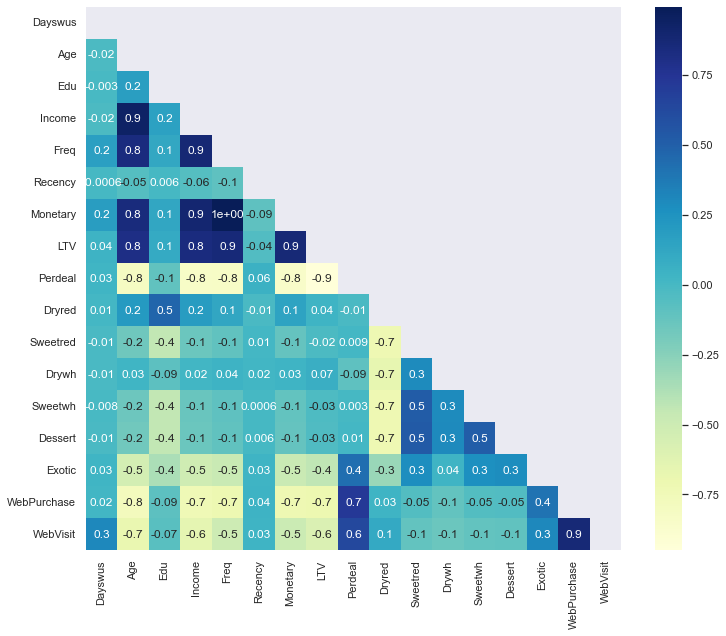

In [208]:
# spearman correlation since we are dealing with no gaussian data

cor_spearman = www.corr(method ='spearman')
cor_heatmap(cor_spearman)

<hr>
<a class="anchor" id="relevancy">
    
### 3.1.2. Relevancy
    
</a>

<Figure size 720x720 with 0 Axes>

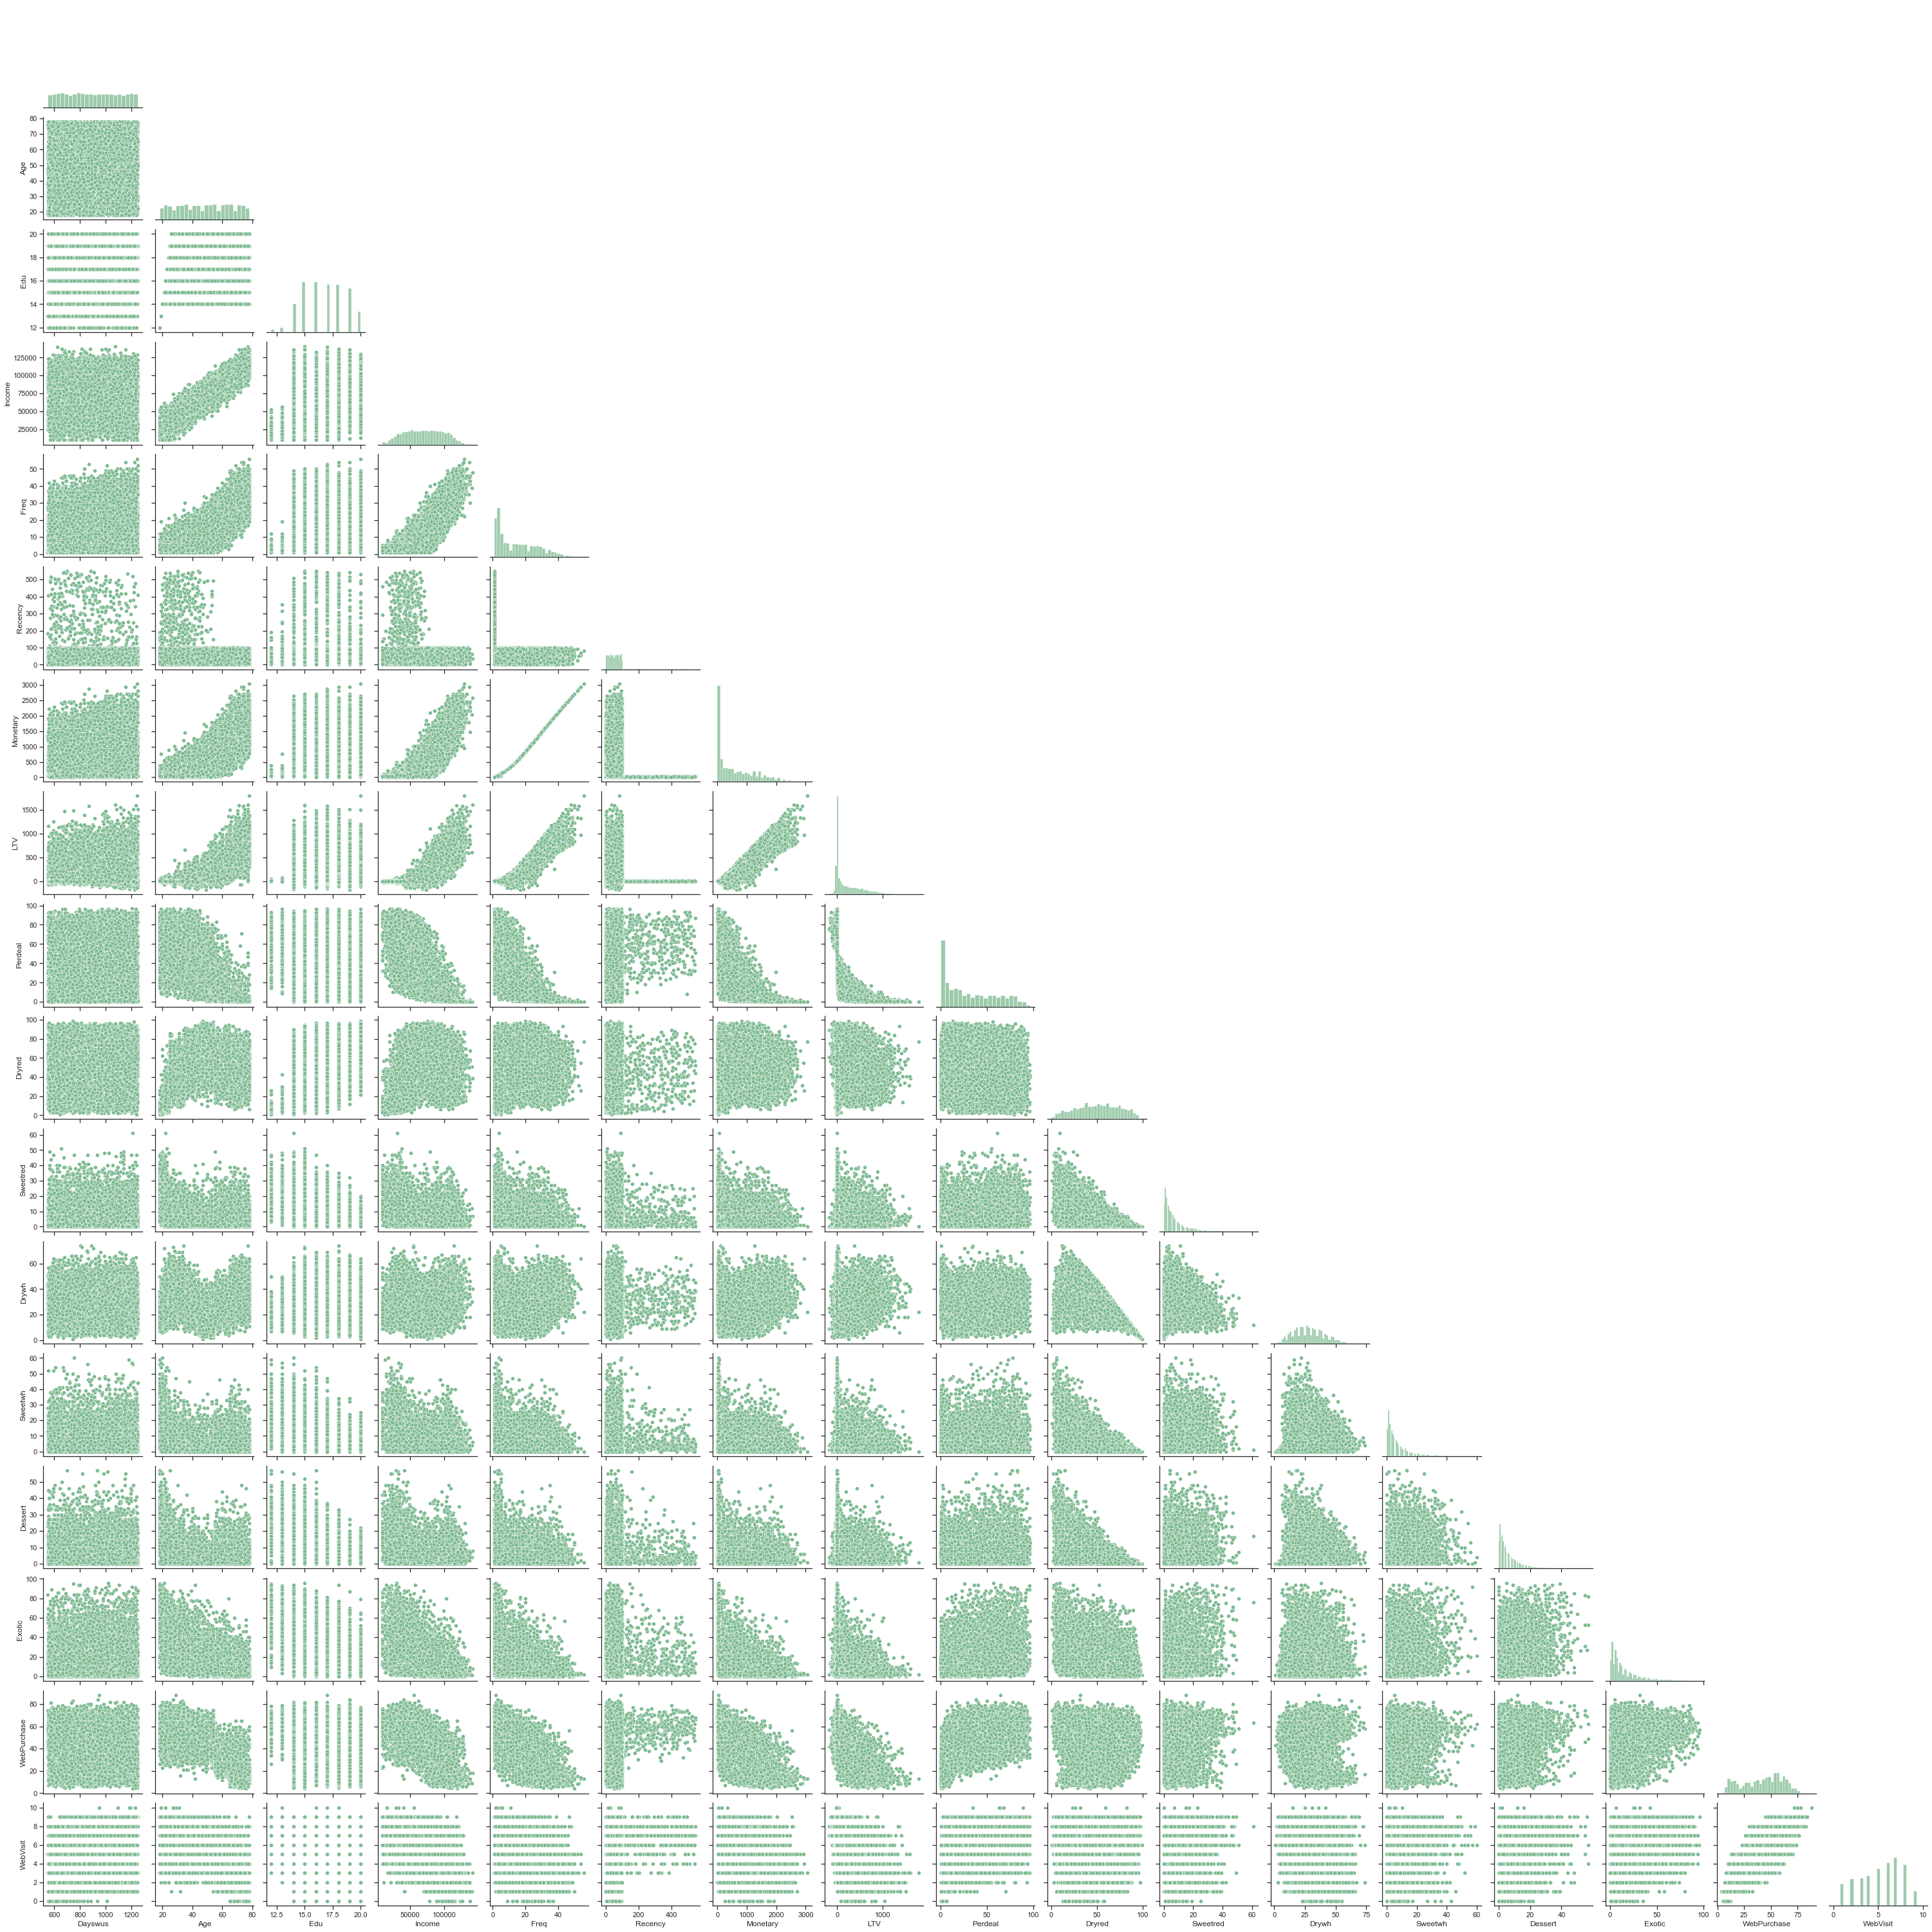

In [209]:
# In order to analyse the importance of detailed variables, we decided
# to perform some new visualizations
sns.set_theme(style="ticks", palette = "crest")
plt.figure(figsize=(10,10))

sns.pairplot(www, corner=True, palette = "husl")

Every variables has discrimate power 

<hr>
<a class="anchor" id="analysis">
    
# 4. Data Analysis
    
</a>

### RFM

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

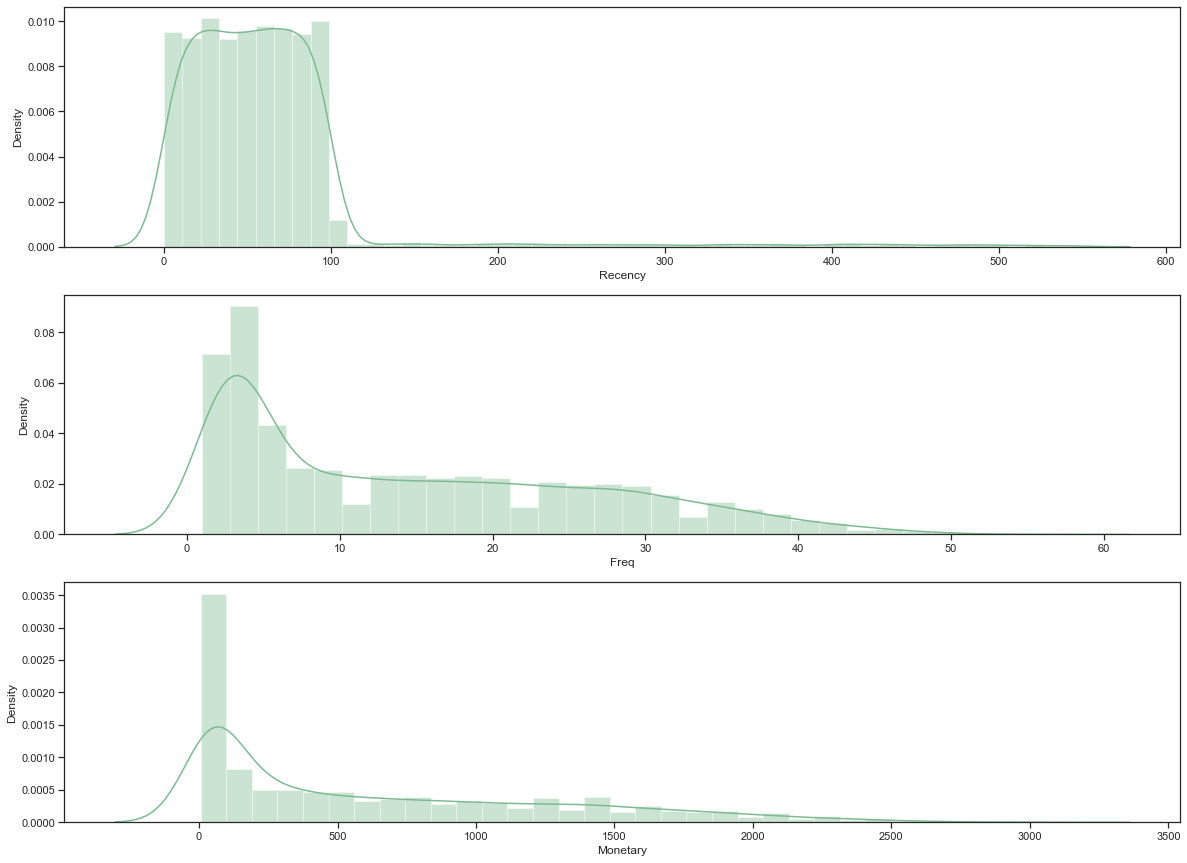

In [210]:
#plotting the RFM gralysis by Recency, Frequency and Monetary
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
sns.distplot(www['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(www['Freq'])
plt.subplot(3, 1, 3)
sns.distplot(www['Monetary'])

### RFM with LTV

In [211]:
#3D plot using RFM Analysis and LTV variable 
fig = px.scatter_3d(www, x='Recency', y='Freq', z='Monetary', color='LTV')
fig.update_layout(scene_zaxis_type="log")
fig.show()

### Education, Income, Age, LTV

In [212]:
#3D plot to correlate and analyse the variables Income, Age, Education and LTV
start, end = 750, 1500

fig = go.Figure(data=go.Scatter3d(
    x=www['Income'][start:end],
    y=www['Age'][start:end],
    z=www['Edu'][start:end],
    text=www['WebPurchase'][start:end],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=750,
        #size=www['WebPurchase'][start:end],
        color = www['LTV'][start:end],
        colorscale = 'Viridis',
        colorbar_title = 'LTV<br>',
        line_color='rgb(140, 140, 170)'
    )
))


fig.update_layout(height=800, width=800,
                  title='Examining Education, Income and Age according to LTV',
                  scene = dict(xaxis=dict(title='Income', titlefont_color='black'),
                               yaxis=dict(title='Age', titlefont_color='black'),
                               zaxis=dict(title='Education', titlefont_color='black'),
    
                           ))


fig.show()

###  Most popular products

In [213]:
#list with wines names
lista = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert']

www['most_popular'] = www[lista].idxmax(axis=1)

In [214]:
#Histogram with the most popular products
fig = px.histogram(www, x="most_popular", category_orders=lista)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

In [215]:
www.drop(['most_popular'], axis=1, inplace=True)

In [216]:
# After analyzing the heatmap, we decided to drop some highly correlated variables
www.drop(['Age', 'WebVisit', 'Edu', 'Recency', 'Dayswus'], axis = 1, inplace = True)

In [217]:
www_out.drop(['Age', 'WebVisit', 'Edu', 'Recency', 'Dayswus'], axis = 1, inplace = True)

<hr>
<a class="anchor" id="featurescalling">
    
# 5. Feature Scaling
    
</a>

<hr>
<a class="anchor" id="minmax">
    
##  Standard Scaler
    
</a>

In [218]:
www_standard = www.copy()

In [219]:
# Scale the data using Standard Scaler
scaler_ss = StandardScaler().fit(www_standard)
scaled_feat = scaler_ss.transform(www_standard)
scaled_feat

array([[ 0.29918239,  0.43853037,  0.30499941, ..., -0.76392683,
        -0.90194791, -0.33782053],
       [ 1.2674196 ,  1.77637496,  1.88907807, ..., -0.50084477,
        -0.96100566, -1.20069163],
       [-1.53764515, -0.89931422, -0.91007846, ...,  1.86689379,
         1.8737662 ,  0.95648612],
       ...,
       [-1.08354067, -0.98292951, -0.89772697, ...,  1.99843482,
         1.46036197,  0.84862723],
       [-0.60349671, -1.15016008, -0.94713293, ...,  0.81456554,
        -0.19325495,  0.95648612],
       [ 0.89775483,  0.85660681,  0.80214691, ..., -0.50084477,
        -0.72477467, -0.44567942]])

In [220]:
www_standard = pd.DataFrame(scaled_feat, columns = www.columns, index=www.index)
www_standard.head()

Income      Freq  Monetary       LTV   Perdeal    Dryred  Sweetred  \
Custid                                                                         
5325    0.299182  0.438530  0.304999  0.798969 -0.904847  0.699033 -0.385035   
3956    1.267420  1.776375  1.889078  1.120113 -1.084382 -0.073840 -0.911136   
3681   -1.537645 -0.899314 -0.910078 -0.745259  2.003618 -2.006021  2.903102   
2829   -0.309286 -1.066545 -0.913166 -0.741842  1.357293  1.514842 -0.779611   
8788   -0.162271 -1.066545 -0.914710 -0.707678  0.100548  1.471905 -0.911136   

           Drywh   Sweetwh   Dessert    Exotic  WebPurchase  
Custid                                                       
5325   -0.204044 -0.632125 -0.763927 -0.901948    -0.337821  
3956    1.388437 -0.759612 -0.500845 -0.961006    -1.200692  
3681   -1.159533  3.192470  1.866894  1.873766     0.956486  
2829   -1.398405 -0.759612 -0.763927  2.287170     0.902557  
8788   -1.318781 -0.632125 -0.763927  0.692611     1.118274

In [221]:
www_standard.describe().round(2)

Income     Freq  Monetary      LTV  Perdeal   Dryred  Sweetred  \
count  9897.00  9897.00   9897.00  9897.00  9897.00  9897.00   9897.00   
mean     -0.00     0.00     -0.00    -0.00     0.00     0.00      0.00   
std       1.00     1.00      1.00     1.00     1.00     1.00      1.00   
min      -2.19    -1.15     -0.96    -1.33    -1.16    -2.13     -0.91   
25%      -0.80    -0.90     -0.87    -0.73    -0.94    -0.76     -0.65   
50%       0.01    -0.23     -0.37    -0.52    -0.26     0.01     -0.39   
75%       0.81     0.77      0.70     0.54     0.85     0.78      0.40   
max       2.56     3.45      3.74     5.40     2.33     2.07      7.11   

         Drywh  Sweetwh  Dessert   Exotic  WebPurchase  
count  9897.00  9897.00  9897.00  9897.00      9897.00  
mean     -0.00     0.00     0.00    -0.00        -0.00  
std       1.00     1.00     1.00     1.00         1.00  
min      -2.19    -0.89    -0.90    -0.96        -2.06  
25%      -0.76    -0.63    -0.63    -0.72        -0.82  
50%      -0.04    -0.38    -0.37    -0.37         0.15  
75%       0.67     0.39     0.29     0.34         0.79  
max       3.62     6.76     6.60     4.71         2.47

In [222]:
# scaling the outliers dataframe 

out_scaled_feat = scaler_ss.transform(www_out)
www_out_standard = pd.DataFrame(out_scaled_feat, columns = www_out.columns, index=www_out.index)
www_out_standard.head()

Income     Freq  Monetary       LTV   Perdeal    Dryred  Sweetred  \
Custid                                                                        
4324   -1.522765 -1.15016 -0.950221 -0.724760  1.070037 -1.877209  5.665136   
3142   -0.895379 -1.15016 -0.940957 -0.738426  1.644549 -0.546151  0.404118   
3950   -1.116065 -1.15016 -0.953309 -0.741842  2.183153 -1.705460  1.193271   
3012   -1.244889 -1.15016 -0.948677 -0.721344  0.423711 -1.662522 -0.516560   
5642   -1.476671 -1.15016 -0.948677 -0.717927  0.244176 -1.705460  0.930220   

           Drywh   Sweetwh   Dessert    Exotic  WebPurchase  
Custid                                                       
4324   -1.637277  3.447443 -0.895468  1.873766     0.093615  
3142    0.512572  0.005307  0.419942  2.759632    -0.499609  
3950   -1.398405  6.889579 -0.632386  4.413249    -0.176032  
3012    1.547685  3.064983 -0.106222  2.700575     1.064345  
5642   -1.318781  3.574929  2.787681  3.054921    -0.283891

<hr>
<a class="anchor" id="clustmeth">
    
# 6. Clustering Methods
    
</a>

### Spliting our features into perspectives

In [223]:
customer_value = ['Freq', 'LTV', 'Monetary', 'Perdeal','Income', 'WebPurchase']

wine_preferences = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']


www_cv = www_standard[customer_value]
www_wp = www_standard[wine_preferences]

### Defining cluster profiles for posterior analysis

In [224]:
# Create a function that will show us, the profile of each cluster after 
# creating the clusters with each of the studied methods
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

<hr>
<a class="anchor" id="k-means+hc">
    
## 6.1 K-Means + Hierarchical clustering
    
</a>

In [225]:
# Create a function to compute the r squared for each linkage method used in hierarchical clustering
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=1, max_k=13):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [226]:
# Obtaining the R² scores for each cluster solution
def r2_scores(dataframe):
    r2_scores = {}

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(dataframe, hierarchical.set_params(linkage=linkage))  
    
    return pd.DataFrame(r2_scores)

### Customer Value Perspective

In [227]:
# Initialize the K-Means method, with a high number of initial clusters
kmeans_cv = KMeans(n_clusters=35, init = 'k-means++', n_init=20, random_state=93)
km_cv_labels = kmeans_cv.fit_predict(www_cv)

In [228]:
www_km_cv = pd.concat([www_cv, pd.Series(km_cv_labels, name='km_cv_labels', index=www_cv.index)], axis=1)

In [229]:
# the best linkage is ward

#value_r2_scores = r2_scores(www_cv)

# Visualizing the R² scores for each cluster solution on value variables
#value_r2_scores.plot.line(figsize=(10,7))

#plt.title("Value Variables:\nR² plot for various clustering methods\n", fontsize=21)
#plt.legend(title="Cluster methods", title_fontsize=11)
#plt.xlabel("Number of clusters", fontsize=13)
#plt.ylabel("R² metric", fontsize=13)
#plt.show()

In [230]:
# Take the centroids from the previous clusters
centroids = pd.DataFrame(kmeans_cv.cluster_centers_, columns = www_cv.columns)

In [231]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)

hclust_labels = hclust.fit_predict(centroids)

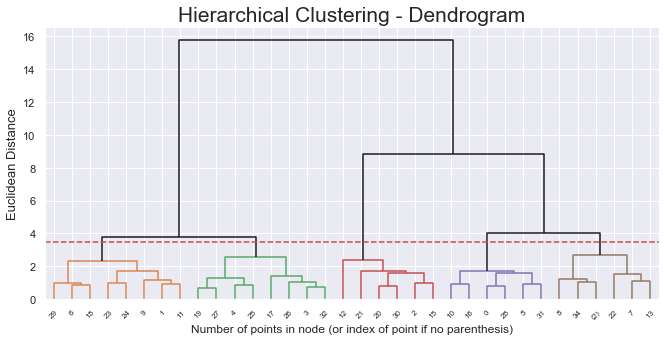

In [232]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)


for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)


sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 3.5
dendrogram(linkage_matrix, truncate_mode='level', labels=centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [233]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=5
)
hclust_labels = hclust.fit_predict(centroids)
centroids['hclust_labels'] = hclust_labels

centroids  # centroid's cluster labels

Freq       LTV  Monetary   Perdeal    Income  WebPurchase  \
0   0.505143  0.237456  0.391503 -0.754918  0.521613    -0.638714   
1  -0.741295 -0.766915 -0.728753  0.992441 -0.271186     0.910783   
2   2.250062  1.978553  2.435595 -1.117197  1.671378    -1.560393   
3  -0.953010 -0.765844 -0.872802  1.666230 -0.842336     1.341918   
4  -0.890770 -0.683800 -0.829980 -0.164692 -1.344014     0.830520   
5   1.026307  0.796533  1.002904 -0.846669  0.665261    -0.717602   
6  -0.464057 -0.480918 -0.543277 -0.481834  0.030939     0.856569   
7   0.339014  0.016191  0.206729 -0.572148  0.243868     0.686839   
8  -0.551279 -0.549158 -0.605818 -0.261902  0.060796    -0.544608   
9  -0.144177 -0.812490 -0.278345  0.880455  0.048350     0.105630   
10  0.539542  0.449702  0.431659 -1.012448  0.869498    -1.433059   
11 -0.846296 -0.775381 -0.800931  1.217856 -0.447316     0.045640   
12  2.427120  3.400755  2.632360 -1.120029  1.701555    -1.415237   
13  0.881332  0.602303  0.830768 -0.744617  0.579214     0.487648   
14  0.230065 -0.216960  0.088989 -0.297380  0.151630    -0.563881   
15  1.704750  2.428955  1.809539 -1.100100  1.348663    -1.525489   
16  1.041991  0.900353  1.022537 -1.068319  1.130605    -1.497067   
17 -0.968011 -0.755295 -0.899329  1.652147 -1.397310    -0.067726   
18 -0.155614 -0.353619 -0.292190 -0.463308 -0.269574     0.156752   
19 -0.954119 -0.727282 -0.880708  0.829572 -1.347035     1.370038   
20  1.653739  1.326114  1.749974 -1.094937  1.401613    -1.492891   
21  1.825008  2.093517  1.947054 -1.049208  1.354276    -0.198595   
22  0.556985 -0.473937  0.454359  0.289434  0.587283     0.181812   
23 -0.908766 -0.688457 -0.839447  0.157063 -0.987822    -0.306635   
24 -0.825587 -0.673092 -0.785381  0.113563 -0.391597     0.446583   
25 -0.887031 -0.696486 -0.821537  0.205863 -0.703918     1.299939   
26 -0.978404 -0.741247 -0.913105  1.680371 -1.666099     1.119290   
27 -0.949414 -0.730701 -0.870964  0.907368 -1.190725     0.686839   
28  0.692860  0.428381  0.609334 -0.786487  1.116479    -0.231210   
29 -0.087911 -0.574546 -0.228566  0.232399 -0.158475     0.808288   
30  1.248676  1.685527  1.269717 -1.070332  1.101234    -1.411179   
31  1.292194  1.238275  1.321597 -0.922143  1.135701    -0.168691   
32 -0.925810 -0.786415 -0.854693  1.724570 -0.718332     0.597470   
33  0.002947 -0.166568 -0.141517 -0.650918  0.572903    -0.018626   
34 -0.071319 -0.142450 -0.212543 -0.823575  0.508144    -1.072576   

    hclust_labels  
0               3  
1               4  
2               2  
3               1  
4               1  
5               3  
6               4  
7               0  
8               0  
9               4  
10              3  
11              4  
12              2  
13              0  
14              0  
15              2  
16              3  
17              1  
18              4  
19              1  
20              2  
21              2  
22              0  
23              4  
24              4  
25              1  
26              1  
27              1  
28              3  
29              4  
30              2  
31              3  
32              1  
33              0  
34              0

In [234]:
# Mapper between concatenated hierarchical clusters
cluster_mapper = centroids['hclust_labels'].to_dict()

# Mapping the hierarchical clusters on the centroids to the observations
www_km_cv['kmeans_labels'] = www_km_cv.apply(
    lambda row: cluster_mapper[(row['km_cv_labels'])], axis=1)

www_km_cv.drop('km_cv_labels', axis=1, inplace=True)

In [235]:
www_km_cv.groupby('kmeans_labels').mean()

Freq       LTV  Monetary   Perdeal    Income  WebPurchase
kmeans_labels                                                               
0              0.114311 -0.139284  0.002925 -0.492672  0.352206    -0.121807
1             -0.939170 -0.736033 -0.868339  1.067938 -1.147266     0.933653
2              1.758703  1.996452  1.866901 -1.093178  1.393614    -1.388901
3              0.829243  0.653180  0.772447 -0.914371  0.897934    -0.905660
4             -0.566032 -0.645417 -0.595594  0.348780 -0.310685     0.419426

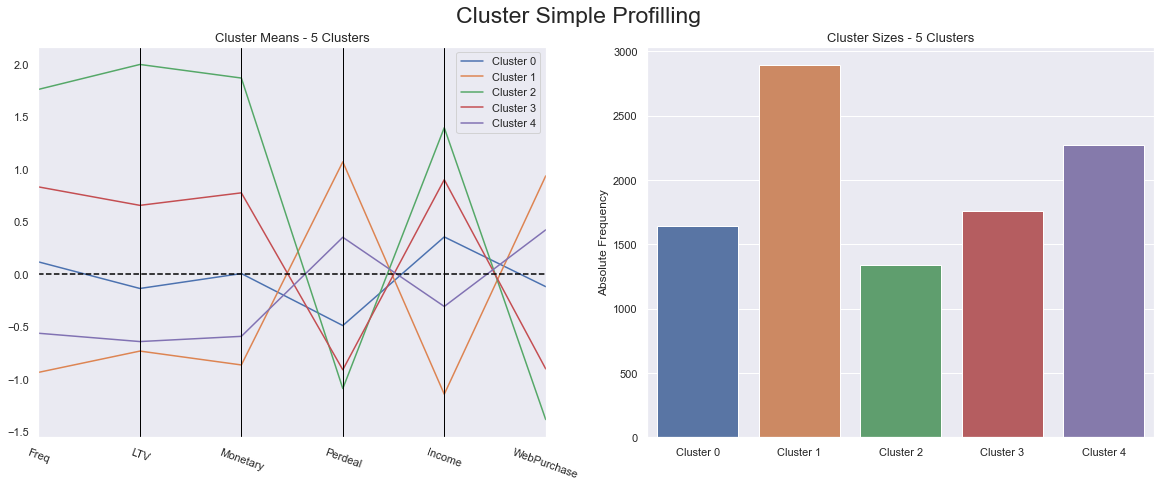

In [236]:
cluster_profiles(www_km_cv, ['kmeans_labels'], (20,7))

### Wine Preferences Perspective

In [237]:
# Initialize the K-Means method, with a high number of initial clusters
kmeans_wp = KMeans(n_clusters=35, init = 'k-means++', n_init=20, random_state=93)
km_wp_labels = kmeans_wp.fit_predict(www_wp)

In [238]:
www_km_wp = pd.concat([www_wp, pd.Series(km_wp_labels, name='km_wp_labels', index=www_wp.index)], axis=1)

In [239]:
# the best linkage is ward

#value_r2_scores = r2_scores(www_wp)

# Visualizing the R² scores for each cluster solution on value variables
#value_r2_scores.plot.line(figsize=(10,7))

#plt.title("Value Variables:\nR² plot for various clustering methods\n", fontsize=21)
#plt.legend(title="Cluster methods", title_fontsize=11)
#plt.xlabel("Number of clusters", fontsize=13)
#plt.ylabel("R² metric", fontsize=13)
#plt.show()

In [240]:
# Take the centroids from the previous clusters
centroids = pd.DataFrame(kmeans_wp.cluster_centers_, columns = www_wp.columns)

In [241]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)

hclust_labels = hclust.fit_predict(centroids)

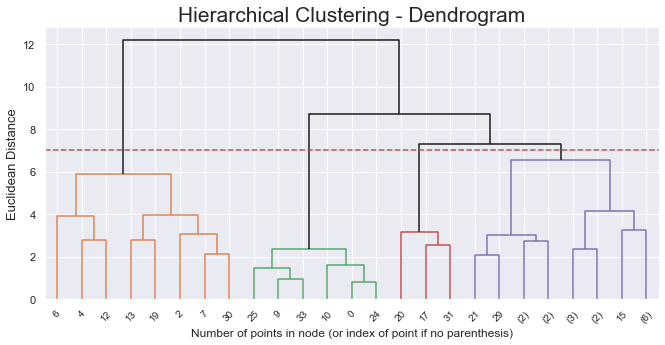

In [242]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)


for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)


sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 7
dendrogram(linkage_matrix, truncate_mode='level', labels=centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [243]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(centroids)
centroids['hclust_labels'] = hclust_labels

centroids  # centroid's cluster labels

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  hclust_labels
0   1.658332 -0.831475 -1.586792 -0.804458 -0.817103 -0.561005              2
1  -0.393966 -0.371310  1.355756 -0.357641 -0.290379 -0.548629              0
2  -1.757076  0.983390 -0.709742  2.942922  2.531596  2.856387              1
3  -0.467637 -0.222763  0.692088  0.596050 -0.101097 -0.444519              0
4  -1.620745  3.178594 -0.485956 -0.158358  2.764572  0.544967              1
5  -0.107780 -0.094771  0.074957 -0.344689  0.656856 -0.424630              0
6  -1.758976  3.638882 -0.662171  2.348103  0.427568  2.405286              1
7  -1.513893  1.838532 -0.485791  1.591806  1.965831  0.627496              1
8  -0.735643  1.004679  0.975511 -0.338169 -0.014904 -0.254021              0
9   0.740183 -0.606216 -0.276951 -0.591829 -0.594211 -0.569391              2
10  1.202732 -0.629339 -1.074784 -0.641211 -0.621500  0.768504              2
11 -1.054456 -0.103318  2.192824 -0.096514 -0.183931 -0.377640              0
12 -1.814507  3.120223 -0.512429  0.345271  2.925486  3.263967              1
13 -1.689449  0.399660 -0.631855  1.048968  4.718436  1.713610              1
14 -1.287428  1.196373  0.934354  1.120814  0.048897 -0.117483              0
15 -1.120012  3.094127  0.012710  0.204631  0.101530  0.028446              0
16  0.194872 -0.441807  0.497958 -0.482853 -0.477367 -0.614135              0
17 -0.950812 -0.156048  0.449560  2.403704 -0.145022 -0.075564              3
18  0.373727 -0.283232 -0.195497 -0.190604 -0.341063  2.499378              0
19 -1.069425  0.090670  0.202262 -0.081670  2.940121  0.232292              1
20 -1.651260  0.537800 -0.333270  4.745297  0.184894  1.410018              3
21 -1.246852  1.401753  0.162735  1.632794  0.459125  2.560470              0
22 -0.168424  0.904476 -0.167774  0.194042 -0.307512 -0.492537              0
23 -0.429336 -0.046550 -0.421449  1.033323  0.999626 -0.314265              0
24  1.185579 -0.677862 -0.979183 -0.659209 -0.657508 -0.587776              2
25  0.370121 -0.461477  0.097098 -0.405483 -0.411745  0.608820              2
26 -0.865017  1.436247 -0.012946 -0.056423  1.303344 -0.286815              0
27 -1.171718  0.004123  1.275412  0.329514  1.139230 -0.322651              0
28 -0.315278  0.517740 -0.306597  0.487219  0.452311  1.190119              0
29 -1.209590  1.722864  0.719736 -0.126692  0.920497  1.777601              0
30 -1.489041 -0.056221 -0.027459  2.384370  2.208476  0.312070              1
31 -1.417376  2.216246 -0.336070  2.706496 -0.116340  0.045500              3
32 -0.615661 -0.130721  1.332756 -0.059328 -0.125079  1.262952              0
33  0.491117 -0.141207 -0.677807 -0.043726 -0.190964 -0.448793              2
34 -1.329081  0.046274  1.336072  0.777117  1.023135  2.379215              0

In [244]:
# Mapper between concatenated hierarchical clusters
cluster_mapper = centroids['hclust_labels'].to_dict()

# Mapping the hierarchical clusters on the centroids to the observations
www_km_wp['kmeans_labels'] = www_km_wp.apply(
    lambda row: cluster_mapper[(row['km_wp_labels'])], axis=1)

www_km_wp.drop('km_wp_labels', axis=1, inplace=True)

In [245]:
www_km_wp.groupby('kmeans_labels').mean()

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic
kmeans_labels                                                            
0             -0.485027  0.209701  0.671384  0.055784  0.111402  0.013153
1             -1.551140  1.438090 -0.362842  1.391430  2.479760  1.299144
2              0.983824 -0.587620 -0.773271 -0.556919 -0.577344 -0.269530
3             -1.257800  0.853047  0.008956  2.966051 -0.070950  0.254988

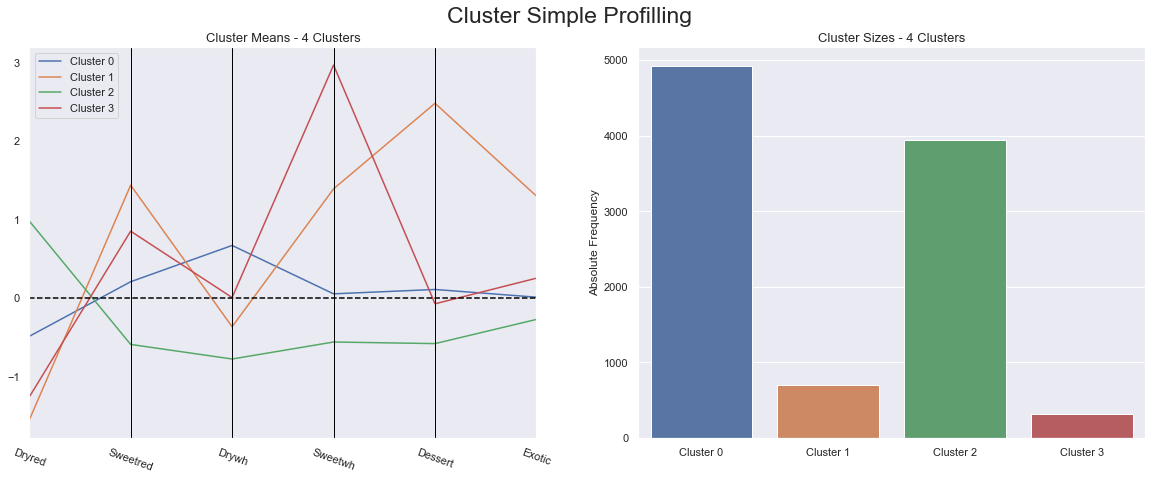

In [246]:
cluster_profiles(www_km_wp, ['kmeans_labels'], (20,7))

<hr>
<a class="anchor" id="som+hc">
    
## 6.2 Self Organizing Maps + Hierarchical
    
</a>

### Customer Value Perspective

In [247]:
# defined in the previous cluster methods
np.random.seed(93)

sm_cv = sompy.SOMFactory().build(
    www_cv.values, 
    mapsize=[20, 20], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=customer_value
)

# Define a certain number of epochs so, the SOM algorithm converge
sm_cv.train(n_job=-1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 120

 epoch: 1 ---> elapsed time:  0.040000, quantization error: 1.272067

 epoch: 2 ---> elapsed time:  0.038000, quantization error: 2.178886

 epoch: 3 ---> elapsed time:  0.038000, quantization error: 2.053714

 epoch: 4 ---> elapsed time:  0.039000, quantization error: 2.033028

 epoch: 5 ---> elapsed time:  0.039000, quantization error: 1.986413

 epoch: 6 ---> elapsed time:  0.040000, quantization error: 1.982513

 epoch: 7 ---> elapsed time:  0.038000, quantization error: 1.978922

 epoch: 8 ---> elapsed time:  0.041000, quantization error: 1.975245

 epoch: 9 ---> elapsed time:  0.044000, quantization error: 1.971521

 epoch: 10 ---> elapsed time:  0.042000, quantization error: 1.967769

 epoch: 11 ---> elapsed time:  0.042000, quantization error: 1.963947

 epoch: 12 ---> elapsed time:  0.061000, quantization error: 1.960049

 epoch: 13 ---> 

 epoch: 115 ---> elapsed time:  0.044000, quantization error: 0.625777

 epoch: 116 ---> elapsed time:  0.047000, quantization error: 0.608263

 epoch: 117 ---> elapsed time:  0.045000, quantization error: 0.591157

 epoch: 118 ---> elapsed time:  0.046000, quantization error: 0.574263

 epoch: 119 ---> elapsed time:  0.048000, quantization error: 0.557414

 epoch: 120 ---> elapsed time:  0.046000, quantization error: 0.540434

 Finetune training...
 radius_ini: 1.666667 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.050000, quantization error: 0.523404

 epoch: 2 ---> elapsed time:  0.044000, quantization error: 0.710809

 epoch: 3 ---> elapsed time:  0.048000, quantization error: 0.699494

 epoch: 4 ---> elapsed time:  0.048000, quantization error: 0.696048

 epoch: 5 ---> elapsed time:  0.044000, quantization error: 0.693621

 epoch: 6 ---> elapsed time:  0.047000, quantization error: 0.691387

 epoch: 7 ---> elapsed time:  0.054000, quantization error: 0.6

 epoch: 110 ---> elapsed time:  0.036000, quantization error: 0.476494

 epoch: 111 ---> elapsed time:  0.037000, quantization error: 0.474489

 epoch: 112 ---> elapsed time:  0.043000, quantization error: 0.472375

 epoch: 113 ---> elapsed time:  0.042000, quantization error: 0.470195

 epoch: 114 ---> elapsed time:  0.042000, quantization error: 0.468160

 epoch: 115 ---> elapsed time:  0.042000, quantization error: 0.465983

 epoch: 116 ---> elapsed time:  0.039000, quantization error: 0.463958

 epoch: 117 ---> elapsed time:  0.037000, quantization error: 0.461949

 epoch: 118 ---> elapsed time:  0.038000, quantization error: 0.459955

 epoch: 119 ---> elapsed time:  0.045000, quantization error: 0.457922

 epoch: 120 ---> elapsed time:  0.044000, quantization error: 0.455960

 Final quantization error: 0.453949
 train took: 10.567000 seconds


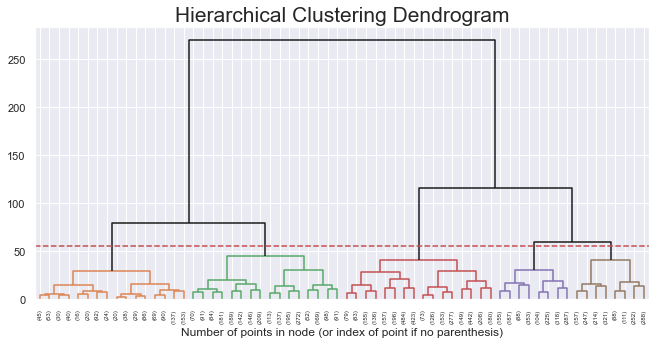

In [248]:
# let's see the best number of cluster for hierarchical
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(www_cv)


counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)


for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)


sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 55
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.show()

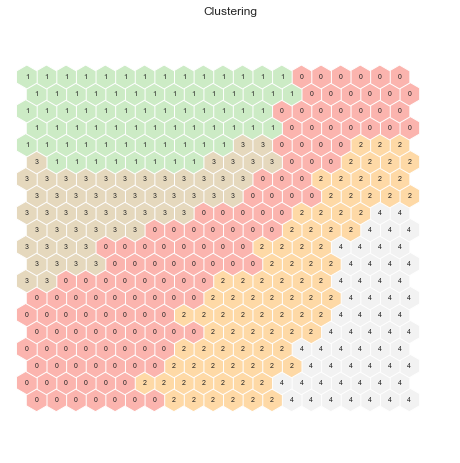

In [249]:
# Perform Hierarchical on top of Som algorithm
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm_cv.codebook.matrix)
sm_cv.cluster_labels = nodeclus_labels  

hits  = HitMapView(8, 8,"Clustering",text_size=10)
hits.show(sm_cv, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [250]:
# Check the nodes with the respective cluster to which it belongs
nodes_cv = sm_cv.codebook.matrix

nodesh_cv = pd.DataFrame(nodes_cv, columns=customer_value)
nodesh_cv['som_h_label'] = nodeclus_labels
nodesh_cv

Freq       LTV  Monetary   Perdeal    Income  WebPurchase  \
0   -0.974120 -0.744014 -0.907079  1.693782 -1.550105     1.262407   
1   -0.972167 -0.740611 -0.902444  1.494590 -1.510041     1.239727   
2   -0.965674 -0.736810 -0.894397  1.276290 -1.426356     1.247283   
3   -0.960704 -0.733370 -0.885575  1.084014 -1.319267     1.290065   
4   -0.958427 -0.727610 -0.882161  0.883181 -1.313312     1.237322   
..        ...       ...       ...       ...       ...          ...   
395  1.784467  1.629513  1.900177 -1.101807  1.464854    -1.553736   
396  1.682266  1.430058  1.781335 -1.097303  1.399006    -1.543587   
397  1.581356  1.272270  1.663341 -1.089637  1.329745    -1.552593   
398  1.471984  1.155017  1.534660 -1.090224  1.344868    -1.533305   
399  1.391033  1.072873  1.439220 -1.097454  1.440810    -1.503353   

     som_h_label  
0              4  
1              4  
2              4  
3              4  
4              4  
..           ...  
395            1  
396            1  
397            1  
398            1  
399            1  

[400 rows x 7 columns]

In [251]:
# Obtaining BMUs
bmus_map_cv = sm_cv.find_bmu(www_cv)[0] 

df_bmus_cv = pd.DataFrame(
    np.concatenate((www_cv, np.expand_dims(bmus_map_cv,1)), axis=1),
    index=www_cv.index, columns=np.append(www_cv[customer_value].columns,"BMU")
)
df_bmus_cv

Freq       LTV  Monetary   Perdeal    Income  WebPurchase    BMU
Custid                                                                      
5325    0.438530  0.798969  0.304999 -0.904847  0.299182    -0.337821  232.0
3956    1.776375  1.120113  1.889078 -1.084382  1.267420    -1.200692  397.0
3681   -0.899314 -0.745259 -0.910078  2.003618 -1.537645     0.956486   60.0
2829   -1.066545 -0.741842 -0.913166  1.357293 -0.309286     0.902557  200.0
8788   -1.066545 -0.707678 -0.914710  0.100548 -0.162271     1.118274   12.0
...          ...       ...       ...       ...       ...          ...    ...
1383    0.354915 -0.082471  0.227803 -0.366243  0.392317    -0.823186  248.0
4070    0.271300  0.614481  0.141342 -0.976661  0.526235    -1.308551  219.0
7909   -0.982930 -0.704261 -0.897727 -0.330336 -1.083541     0.848627    9.0
4158   -1.150160 -0.714511 -0.947133  0.100548 -0.603497     0.956486   11.0
4914    0.856607  0.279671  0.802147 -0.904847  0.897755    -0.445679  235.0

[9897 rows x 7 columns]

In [252]:
# Get cluster labels for each observation
df_somf_cv = df_bmus_cv.merge(nodesh_cv['som_h_label'], 'left', left_on="BMU", right_index=True)

df_somf_cv.drop('BMU', axis=1, inplace=True)

In [253]:
df_somf_cv.groupby('som_h_label').mean()

Freq       LTV  Monetary   Perdeal    Income  WebPurchase
som_h_label                                                               
0            0.012022 -0.215439 -0.092558 -0.443412  0.244624     0.085050
1            1.575236  1.689970  1.651475 -1.060885  1.298789    -1.241063
2           -0.722598 -0.706158 -0.709333  0.363398 -0.670641     0.564251
3            0.619012  0.457990  0.527288 -0.896927  0.789451    -1.022210
4           -0.945518 -0.754260 -0.873819  1.396148 -1.073964     0.896750

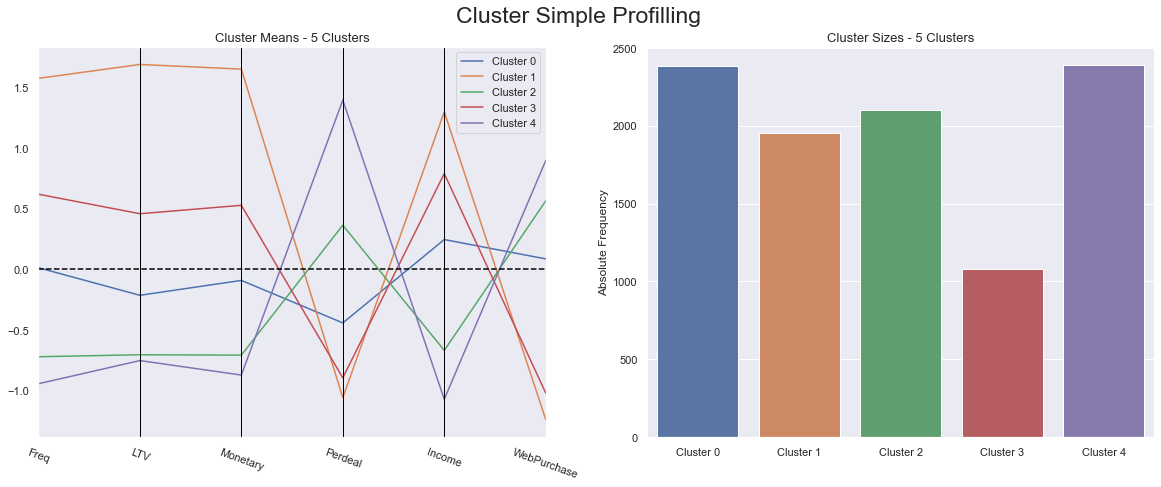

In [254]:
cluster_profiles(df_somf_cv, ['som_h_label'], (20,7))

### Wine Preferences Perspective

In [255]:
# defined in the previous cluster methods
np.random.seed(93)

sm_wp = sompy.SOMFactory().build(
    www_wp.values, 
    mapsize=[20, 20], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=wine_preferences
)

# Define a certain number of epochs so, the SOM algorithm converge
sm_wp.train(n_job=-1, verbose='info', train_rough_len=110, train_finetune_len=110)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 110

 epoch: 1 ---> elapsed time:  0.033000, quantization error: 1.992323

 epoch: 2 ---> elapsed time:  0.034000, quantization error: 2.150449

 epoch: 3 ---> elapsed time:  0.035000, quantization error: 2.088151

 epoch: 4 ---> elapsed time:  0.033000, quantization error: 2.074986

 epoch: 5 ---> elapsed time:  0.035000, quantization error: 2.064556

 epoch: 6 ---> elapsed time:  0.035000, quantization error: 2.030383

 epoch: 7 ---> elapsed time:  0.037000, quantization error: 2.022067

 epoch: 8 ---> elapsed time:  0.038000, quantization error: 2.018312

 epoch: 9 ---> elapsed time:  0.037000, quantization error: 2.015703

 epoch: 10 ---> elapsed time:  0.040000, quantization error: 2.013124

 epoch: 11 ---> elapsed time:  0.460000, quantization error: 2.010477

 epoch: 12 ---> elapsed time:  0.034000, quantization error: 2.007747

 epoch: 13 ---> 

 epoch: 4 ---> elapsed time:  0.038000, quantization error: 1.078983

 epoch: 5 ---> elapsed time:  0.039000, quantization error: 1.076913

 epoch: 6 ---> elapsed time:  0.040000, quantization error: 1.074567

 epoch: 7 ---> elapsed time:  0.037000, quantization error: 1.072241

 epoch: 8 ---> elapsed time:  0.037000, quantization error: 1.069845

 epoch: 9 ---> elapsed time:  0.036000, quantization error: 1.067410

 epoch: 10 ---> elapsed time:  0.038000, quantization error: 1.064889

 epoch: 11 ---> elapsed time:  0.044000, quantization error: 1.062360

 epoch: 12 ---> elapsed time:  0.039000, quantization error: 1.059762

 epoch: 13 ---> elapsed time:  0.038000, quantization error: 1.057087

 epoch: 14 ---> elapsed time:  0.037000, quantization error: 1.054544

 epoch: 15 ---> elapsed time:  0.037000, quantization error: 1.051933

 epoch: 16 ---> elapsed time:  0.038000, quantization error: 1.049232

 epoch: 17 ---> elapsed time:  0.040000, quantization error: 1.046685

 epoch: 18 -

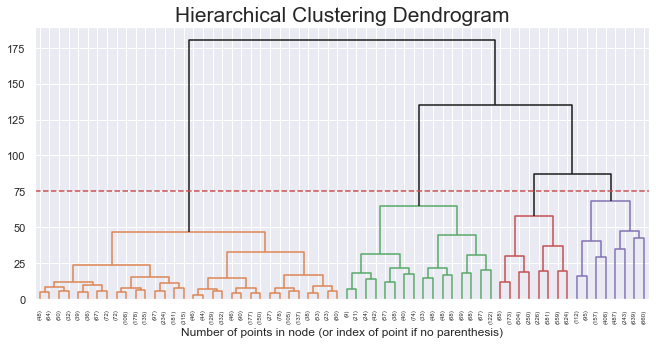

In [256]:
# let's see the best number of cluster for hierarchical
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust.fit_predict(www_wp)


counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)


for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count


linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)


sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 75
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.show()

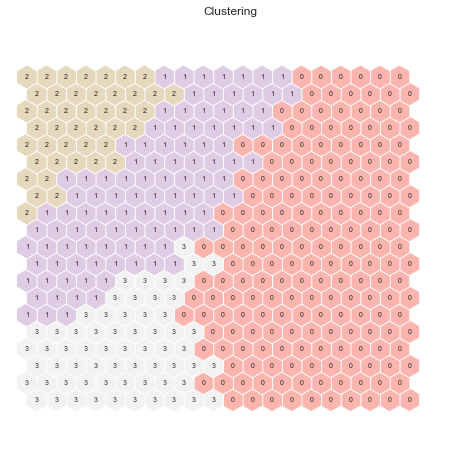

In [257]:
# Perform Hierarchical on top of Som algorithm
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm_wp.codebook.matrix)
sm_wp.cluster_labels = nodeclus_labels  

hits  = HitMapView(8, 8,"Clustering",text_size=10)
hits.show(sm_wp, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [258]:
# Check the nodes with the respective cluster to which it belongs
nodes_wp = sm_wp.codebook.matrix

nodesh_wp = pd.DataFrame(nodes_wp, columns=wine_preferences)
nodesh_wp['som_h_label'] = nodeclus_labels
nodesh_wp

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  som_h_label
0    1.207017 -0.779754 -0.837059 -0.760766 -0.770616 -0.583935            0
1    1.141625 -0.769543 -0.741215 -0.749214 -0.745927 -0.588024            0
2    1.061306 -0.743872 -0.624502 -0.735034 -0.730062 -0.592131            0
3    0.975937 -0.731852 -0.496162 -0.715672 -0.709582 -0.578536            0
4    0.883578 -0.705637 -0.365071 -0.693695 -0.690962 -0.598558            0
..        ...       ...       ...       ...       ...       ...          ...
395 -1.506703  1.475336 -0.319238  0.657516  2.991590  1.140542            2
396 -1.558690  2.187483 -0.415287  0.645953  2.609527  1.386283            2
397 -1.616303  2.312012 -0.435939  1.004009  2.323166  2.114582            2
398 -1.631822  1.912372 -0.487652  1.795712  2.038826  2.215402            2
399 -1.660120  1.417189 -0.544928  2.514383  1.972777  2.354859            2

[400 rows x 7 columns]

In [259]:
# Obtaining BMUs
bmus_map_wp = sm_wp.find_bmu(www_wp)[0] 

df_bmus_wp = pd.DataFrame(
    np.concatenate((www_wp, np.expand_dims(bmus_map_wp,1)), axis=1),
    index=www_wp.index, columns=np.append(www_wp[wine_preferences].columns,"BMU")
)
df_bmus_wp

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic    BMU
Custid                                                                   
5325    0.699033 -0.385035 -0.204044 -0.632125 -0.763927 -0.901948   46.0
3956   -0.073840 -0.911136  1.388437 -0.759612 -0.500845 -0.961006   13.0
3681   -2.006021  2.903102 -1.159533  3.192470  1.866894  1.873766  379.0
2829    1.514842 -0.779611 -1.398405 -0.759612 -0.763927  2.287170  340.0
8788    1.471905 -0.911136 -1.318781 -0.632125 -0.763927  0.692611  260.0
...          ...       ...       ...       ...       ...       ...    ...
1383    1.171343 -0.911136 -0.681789 -0.759612 -0.763927 -0.311370    1.0
4070   -0.889650  0.667169  0.592196  0.387767  0.683025 -0.193255  158.0
7909   -1.920146  2.245474 -1.478029  3.957389  1.998435  1.460362  379.0
4158   -1.404898  0.798694  1.308813  0.515253  0.814566 -0.193255  139.0
4914    0.527283  0.404118 -1.239157  0.515253 -0.500845 -0.724775  188.0

[9897 rows x 7 columns]

In [260]:
# Get cluster labels for each observation
df_somf_wp = df_bmus_wp.merge(nodesh_wp['som_h_label'], 'left', left_on="BMU", right_index=True)

df_somf_wp.drop('BMU', axis=1, inplace=True)

In [261]:
df_somf_wp.groupby('som_h_label').mean()

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic
som_h_label                                                            
0            0.889110 -0.529844 -0.667004 -0.535831 -0.541218 -0.202421
1           -0.680474  0.481703  0.488795  0.335262  0.450241  0.232476
2           -1.481477  1.633245 -0.296597  1.735142  1.607313  1.121160
3           -0.451306 -0.279927  1.217728 -0.144842 -0.197071 -0.468086

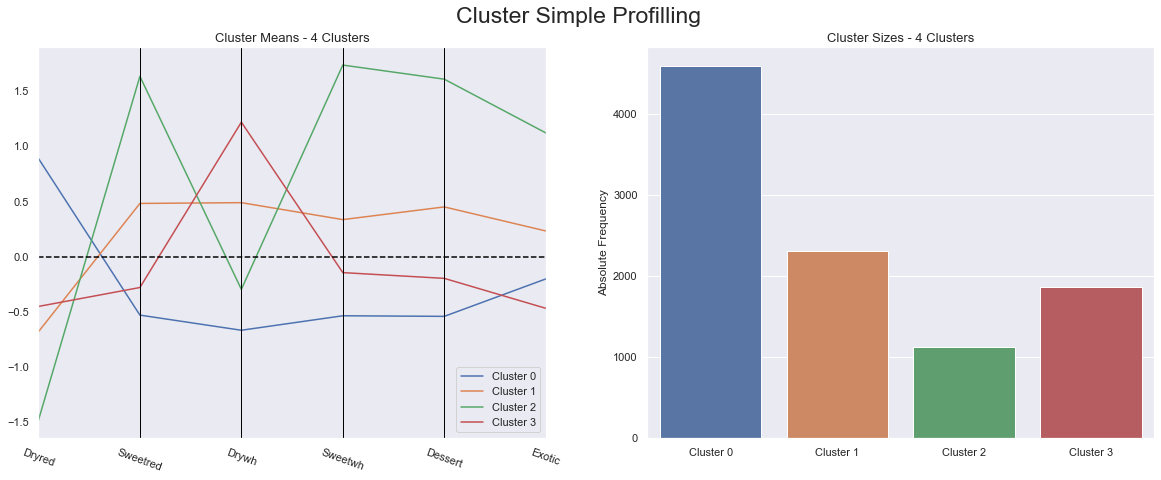

In [262]:
cluster_profiles(df_somf_wp, ['som_h_label'], (20,7))

<hr>
<a class="anchor" id="som+k-means">
    
## 6.3 Self Organizing Maps + K-means
    
</a>

### Customer Value Perspective

In [263]:
# defined in the previous cluster methods
np.random.seed(93)

sm_cv = sompy.SOMFactory().build(
    www_cv.values, 
    mapsize=[20, 20], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=customer_value
)

# Define a certain number of epochs so, the SOM algorithm converge
sm_cv.train(n_job=-1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 120

 epoch: 1 ---> elapsed time:  0.036000, quantization error: 1.272067

 epoch: 2 ---> elapsed time:  0.038000, quantization error: 2.178886

 epoch: 3 ---> elapsed time:  0.041000, quantization error: 2.053714

 epoch: 4 ---> elapsed time:  0.038000, quantization error: 2.033028

 epoch: 5 ---> elapsed time:  0.036000, quantization error: 1.986413

 epoch: 6 ---> elapsed time:  0.042000, quantization error: 1.982513

 epoch: 7 ---> elapsed time:  0.041000, quantization error: 1.978922

 epoch: 8 ---> elapsed time:  0.039000, quantization error: 1.975245

 epoch: 9 ---> elapsed time:  0.044000, quantization error: 1.971521

 epoch: 10 ---> elapsed time:  0.039000, quantization error: 1.967769

 epoch: 11 ---> elapsed time:  0.039000, quantization error: 1.963947

 epoch: 12 ---> elapsed time:  0.041000, quantization error: 1.960049

 epoch: 13 ---> 

 epoch: 115 ---> elapsed time:  0.040000, quantization error: 0.625777

 epoch: 116 ---> elapsed time:  0.055000, quantization error: 0.608263

 epoch: 117 ---> elapsed time:  0.042000, quantization error: 0.591157

 epoch: 118 ---> elapsed time:  0.045000, quantization error: 0.574263

 epoch: 119 ---> elapsed time:  0.040000, quantization error: 0.557414

 epoch: 120 ---> elapsed time:  0.041000, quantization error: 0.540434

 Finetune training...
 radius_ini: 1.666667 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.043000, quantization error: 0.523404

 epoch: 2 ---> elapsed time:  0.040000, quantization error: 0.710809

 epoch: 3 ---> elapsed time:  0.049000, quantization error: 0.699494

 epoch: 4 ---> elapsed time:  0.041000, quantization error: 0.696048

 epoch: 5 ---> elapsed time:  0.041000, quantization error: 0.693621

 epoch: 6 ---> elapsed time:  0.038000, quantization error: 0.691387

 epoch: 7 ---> elapsed time:  0.039000, quantization error: 0.6

 epoch: 110 ---> elapsed time:  0.045000, quantization error: 0.476494

 epoch: 111 ---> elapsed time:  0.045000, quantization error: 0.474489

 epoch: 112 ---> elapsed time:  0.050000, quantization error: 0.472375

 epoch: 113 ---> elapsed time:  0.049000, quantization error: 0.470195

 epoch: 114 ---> elapsed time:  0.044000, quantization error: 0.468160

 epoch: 115 ---> elapsed time:  0.046000, quantization error: 0.465983

 epoch: 116 ---> elapsed time:  0.046000, quantization error: 0.463958

 epoch: 117 ---> elapsed time:  0.044000, quantization error: 0.461949

 epoch: 118 ---> elapsed time:  0.044000, quantization error: 0.459955

 epoch: 119 ---> elapsed time:  0.047000, quantization error: 0.457922

 epoch: 120 ---> elapsed time:  0.043000, quantization error: 0.455960

 Final quantization error: 0.453949
 train took: 10.364000 seconds


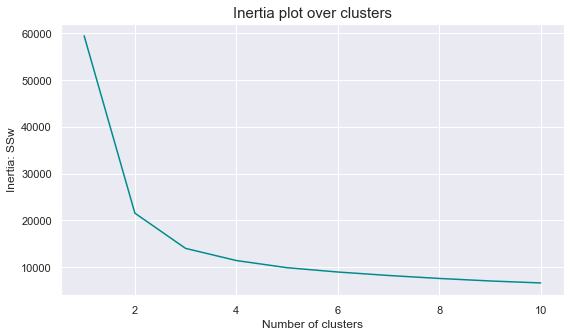

In [99]:
# defining the number of clusters, using the inertia plot

inertia = []
for n_clus in range(1,11): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=93)
    kmclust.fit(www_cv)
    inertia.append(kmclust.inertia_)
    

plt.figure(figsize=(9,5))
plt.plot(range(1,11),inertia,color = 'darkcyan')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

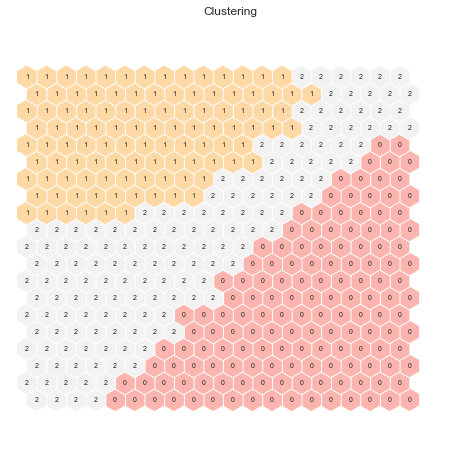

In [99]:
# As we can see by the inertia plot, we can ser that the most suitable number of clusters is 
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=93)
nodeclus_labels = kmeans.fit_predict(sm_cv.codebook.matrix)
sm_cv.cluster_labels = nodeclus_labels  

hits = HitMapView(8, 8,"Clustering", text_size=10)
hits.show(sm_cv, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [100]:
nodes_cv = sm_cv.codebook.matrix

nodesk_cv = pd.DataFrame(nodes_cv, columns=customer_value)
nodesk_cv['som_k_label'] = nodeclus_labels
nodesk_cv

Freq       LTV  Monetary   Perdeal    Income  WebPurchase  \
0   -0.974120 -0.744014 -0.907079  1.693782 -1.550105     1.262407   
1   -0.972167 -0.740611 -0.902444  1.494590 -1.510041     1.239727   
2   -0.965674 -0.736810 -0.894397  1.276290 -1.426356     1.247283   
3   -0.960704 -0.733370 -0.885575  1.084014 -1.319267     1.290065   
4   -0.958427 -0.727610 -0.882161  0.883181 -1.313312     1.237322   
..        ...       ...       ...       ...       ...          ...   
395  1.784467  1.629513  1.900177 -1.101807  1.464854    -1.553736   
396  1.682266  1.430058  1.781335 -1.097303  1.399006    -1.543587   
397  1.581356  1.272270  1.663341 -1.089637  1.329745    -1.552593   
398  1.471984  1.155017  1.534660 -1.090224  1.344868    -1.533305   
399  1.391033  1.072873  1.439220 -1.097454  1.440810    -1.503353   

     som_k_label  
0              0  
1              0  
2              0  
3              0  
4              0  
..           ...  
395            1  
396            1  
397            1  
398            1  
399            1  

[400 rows x 7 columns]

In [101]:
# Obtaining BMUs
bmus_map_cv = sm_cv.find_bmu(www_cv)[0] 

df_bmus_cv2 = pd.DataFrame(
    np.concatenate((www_cv, np.expand_dims(bmus_map_cv,1)), axis=1),
    index=www_cv.index, columns=np.append(www_cv.columns,"BMU")
)
df_bmus_cv2

Freq       LTV  Monetary   Perdeal    Income  WebPurchase    BMU
Custid                                                                      
5325    0.438530  0.798969  0.304999 -0.904847  0.299182    -0.337821  232.0
3956    1.776375  1.120113  1.889078 -1.084382  1.267420    -1.200692  397.0
3681   -0.899314 -0.745259 -0.910078  2.003618 -1.537645     0.956486   60.0
2829   -1.066545 -0.741842 -0.913166  1.357293 -0.309286     0.902557  200.0
8788   -1.066545 -0.707678 -0.914710  0.100548 -0.162271     1.118274   12.0
...          ...       ...       ...       ...       ...          ...    ...
1383    0.354915 -0.082471  0.227803 -0.366243  0.392317    -0.823186  248.0
4070    0.271300  0.614481  0.141342 -0.976661  0.526235    -1.308551  219.0
7909   -0.982930 -0.704261 -0.897727 -0.330336 -1.083541     0.848627    9.0
4158   -1.150160 -0.714511 -0.947133  0.100548 -0.603497     0.956486   11.0
4914    0.856607  0.279671  0.802147 -0.904847  0.897755    -0.445679  235.0

[9897 rows x 7 columns]

In [102]:
# Get cluster labels for each observation
df_somf_cv2 = df_bmus_cv2.merge(nodesk_cv['som_k_label'], 'left', left_on="BMU", right_index=True)

df_somf_cv2.drop('BMU', axis=1, inplace=True)

In [103]:
df_somf_cv2.groupby('som_k_label')[customer_value].mean()

Freq       LTV  Monetary   Perdeal    Income  WebPurchase
som_k_label                                                               
0           -0.843438 -0.727375 -0.799406  0.874190 -0.862671     0.738500
1            1.394199  1.448521  1.437333 -1.036403  1.208815    -1.190877
2            0.128604 -0.121530  0.012438 -0.519119  0.336594    -0.140797

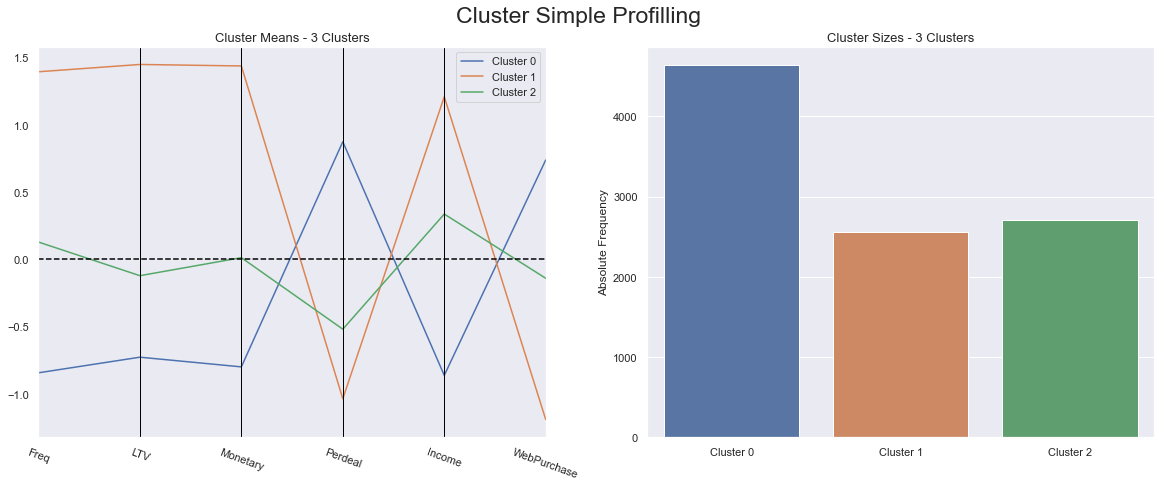

In [104]:
cluster_profiles(df_somf_cv2, ['som_k_label'], (20,7))

### Wine Preferences Perspective

In [105]:
# defined in the previous cluster methods
np.random.seed(93)

sm_wp = sompy.SOMFactory().build(
    www_wp.values, 
    mapsize=[20, 20], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=wine_preferences
)

# Define a certain number of epochs so, the SOM algorithm converge
sm_wp.train(n_job=-1, verbose='info', train_rough_len=110, train_finetune_len=110)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 110

 epoch: 1 ---> elapsed time:  0.063000, quantization error: 1.992323

 epoch: 2 ---> elapsed time:  0.052000, quantization error: 2.150449

 epoch: 3 ---> elapsed time:  0.064000, quantization error: 2.088151

 epoch: 4 ---> elapsed time:  0.065000, quantization error: 2.074986

 epoch: 5 ---> elapsed time:  0.057000, quantization error: 2.064556

 epoch: 6 ---> elapsed time:  0.061000, quantization error: 2.030383

 epoch: 7 ---> elapsed time:  0.061000, quantization error: 2.022067

 epoch: 8 ---> elapsed time:  0.063000, quantization error: 2.018312

 epoch: 9 ---> elapsed time:  0.061000, quantization error: 2.015703

 epoch: 10 ---> elapsed time:  0.061000, quantization error: 2.013124

 epoch: 11 ---> elapsed time:  0.066000, quantization error: 2.010477

 epoch: 12 ---> elapsed time:  0.059000, quantization error: 2.007747

 epoch: 13 ---> 

 epoch: 4 ---> elapsed time:  0.086000, quantization error: 1.078983

 epoch: 5 ---> elapsed time:  0.055000, quantization error: 1.076913

 epoch: 6 ---> elapsed time:  0.050000, quantization error: 1.074567

 epoch: 7 ---> elapsed time:  0.070000, quantization error: 1.072241

 epoch: 8 ---> elapsed time:  0.067000, quantization error: 1.069845

 epoch: 9 ---> elapsed time:  0.050000, quantization error: 1.067410

 epoch: 10 ---> elapsed time:  0.059000, quantization error: 1.064889

 epoch: 11 ---> elapsed time:  0.058000, quantization error: 1.062360

 epoch: 12 ---> elapsed time:  0.053000, quantization error: 1.059762

 epoch: 13 ---> elapsed time:  0.054000, quantization error: 1.057087

 epoch: 14 ---> elapsed time:  0.054000, quantization error: 1.054544

 epoch: 15 ---> elapsed time:  0.054000, quantization error: 1.051933

 epoch: 16 ---> elapsed time:  0.053000, quantization error: 1.049232

 epoch: 17 ---> elapsed time:  0.058000, quantization error: 1.046685

 epoch: 18 -

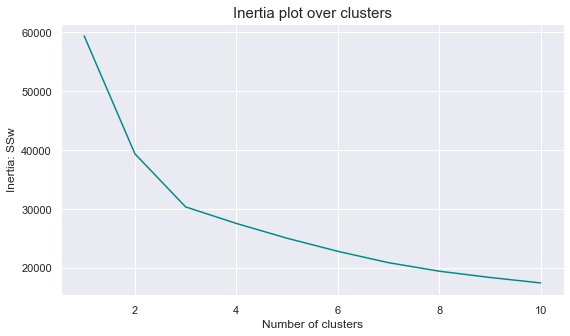

In [107]:
# defining the number of clusters, using the inertia plot

inertia = []
for n_clus in range(1,11): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=93)
    kmclust.fit(www_wp)
    inertia.append(kmclust.inertia_)
    

plt.figure(figsize=(9,5))
plt.plot(range(1,11),inertia,color = 'darkcyan')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

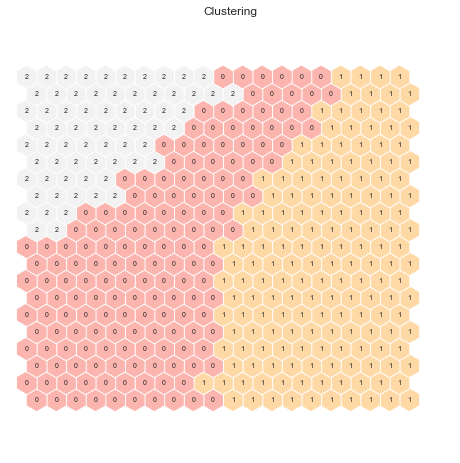

In [106]:
# As we can see by the inertia plot, we can ser that the most suitable number of clusters is 
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=93)
nodeclus_labels = kmeans.fit_predict(sm_wp.codebook.matrix)
sm_wp.cluster_labels = nodeclus_labels  

hits = HitMapView(8, 8,"Clustering", text_size=10)
hits.show(sm_wp, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [107]:
nodes_wp = sm_wp.codebook.matrix

nodesk_wp = pd.DataFrame(nodes_wp, columns=wine_preferences)
nodesk_wp['som_k_label'] = nodeclus_labels
nodesk_wp

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  som_k_label
0    1.207017 -0.779754 -0.837059 -0.760766 -0.770616 -0.583935            1
1    1.141625 -0.769543 -0.741215 -0.749214 -0.745927 -0.588024            1
2    1.061306 -0.743872 -0.624502 -0.735034 -0.730062 -0.592131            1
3    0.975937 -0.731852 -0.496162 -0.715672 -0.709582 -0.578536            1
4    0.883578 -0.705637 -0.365071 -0.693695 -0.690962 -0.598558            1
..        ...       ...       ...       ...       ...       ...          ...
395 -1.506703  1.475336 -0.319238  0.657516  2.991590  1.140542            2
396 -1.558690  2.187483 -0.415287  0.645953  2.609527  1.386283            2
397 -1.616303  2.312012 -0.435939  1.004009  2.323166  2.114582            2
398 -1.631822  1.912372 -0.487652  1.795712  2.038826  2.215402            2
399 -1.660120  1.417189 -0.544928  2.514383  1.972777  2.354859            2

[400 rows x 7 columns]

In [108]:
# Obtaining BMUs
bmus_map_wp = sm_wp.find_bmu(www_wp)[0] 

df_bmus_wp2 = pd.DataFrame(
    np.concatenate((www_wp, np.expand_dims(bmus_map_wp,1)), axis=1),
    index=www_wp.index, columns=np.append(www_wp.columns,"BMU")
)
df_bmus_wp2

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic    BMU
Custid                                                                   
5325    0.699033 -0.385035 -0.204044 -0.632125 -0.763927 -0.901948   46.0
3956   -0.073840 -0.911136  1.388437 -0.759612 -0.500845 -0.961006   13.0
3681   -2.006021  2.903102 -1.159533  3.192470  1.866894  1.873766  379.0
2829    1.514842 -0.779611 -1.398405 -0.759612 -0.763927  2.287170  340.0
8788    1.471905 -0.911136 -1.318781 -0.632125 -0.763927  0.692611  260.0
...          ...       ...       ...       ...       ...       ...    ...
1383    1.171343 -0.911136 -0.681789 -0.759612 -0.763927 -0.311370    1.0
4070   -0.889650  0.667169  0.592196  0.387767  0.683025 -0.193255  158.0
7909   -1.920146  2.245474 -1.478029  3.957389  1.998435  1.460362  379.0
4158   -1.404898  0.798694  1.308813  0.515253  0.814566 -0.193255  139.0
4914    0.527283  0.404118 -1.239157  0.515253 -0.500845 -0.724775  188.0

[9897 rows x 7 columns]

In [109]:
# Get cluster labels for each observation
df_somf_wp2 = df_bmus_wp2.merge(nodesk_wp['som_k_label'], 'left', left_on="BMU", right_index=True)

df_somf_wp2.drop('BMU', axis=1, inplace=True)

In [110]:
df_somf_wp2.groupby('som_k_label')[wine_preferences].mean()

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic
som_k_label                                                            
0           -0.434439 -0.000641  0.784796  0.013089  0.023851 -0.195131
1            0.966125 -0.571667 -0.748091 -0.559032 -0.578281 -0.226804
2           -1.345064  1.408600 -0.024596  1.344856  1.366650  1.022185

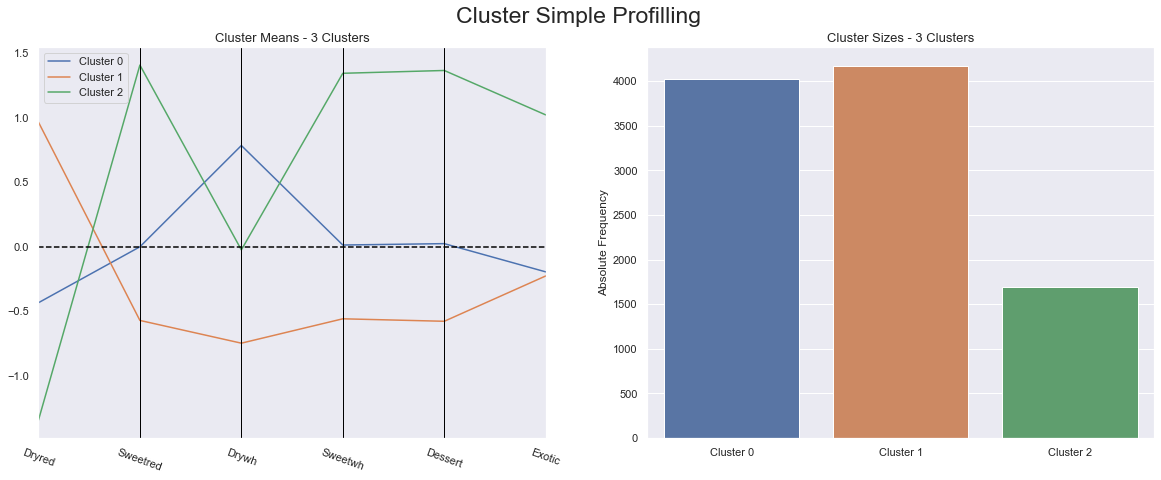

In [111]:
cluster_profiles(df_somf_wp2, ['som_k_label'], (20,7))

<hr>
<a class="anchor" id="meanshiftclust">
    
## 6.4 Mean Shift Clustering
    
</a>

### Customer Value Perspective

In [112]:
# Create the mean shift algorithm, by establishing a value for the quantile
# The quantile value needs to be tested, so we can stay with the appropraite value
# based on the number of clusters it returns
bandwidth_cv = estimate_bandwidth(www_cv, quantile=0.08, random_state=93, n_jobs=-1)
bandwidth_cv

1.0746866221145799

In [113]:
# Perform mean-shift clustering with bandwidth set previously
ms_cv = MeanShift(bandwidth=bandwidth_cv, bin_seeding=True, n_jobs=4)
ms_cv_labels = ms_cv.fit_predict(www_cv)

ms_n_clusters = len(np.unique(ms_cv_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 4


In [114]:
df_ms_cv = pd.concat([www_cv, pd.Series(ms_cv_labels, name='ms_cv_labels', index=www_cv.index)], axis=1)

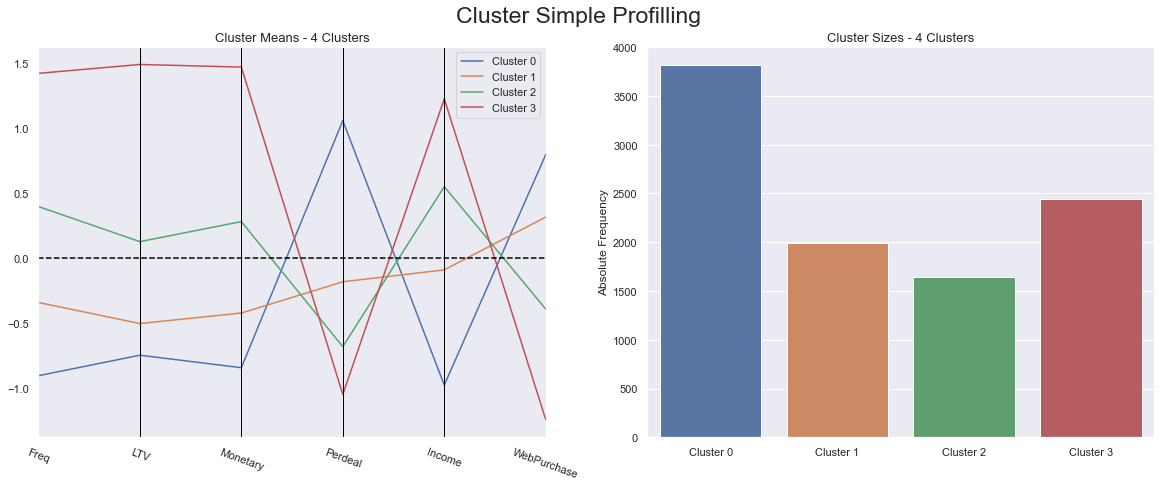

In [115]:
cluster_profiles(df_ms_cv, ['ms_cv_labels'], (20,7))

### Wine Preferences Perspective

In [116]:
# Create the mean shift algorithm, by establishing a value for the quantile
# The quantile value needs to be tested, so we can stay with the appropraite value
# based on the number of clusters it returns
bandwidth_wp = estimate_bandwidth(www_wp, quantile=0.145, random_state=93, n_jobs=-1)
bandwidth_wp

1.8158899385782237

In [117]:
# Perform mean-shift clustering with bandwidth set previously
ms_wp = MeanShift(bandwidth=bandwidth_wp, bin_seeding=True, n_jobs=4)
ms_wp_labels = ms_wp.fit_predict(www_wp)

ms_n_clusters = len(np.unique(ms_wp_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 4


In [118]:
df_ms_wp = pd.concat([www_wp, pd.Series(ms_wp_labels, name='ms_wp_labels', index=www_wp.index)], axis=1)

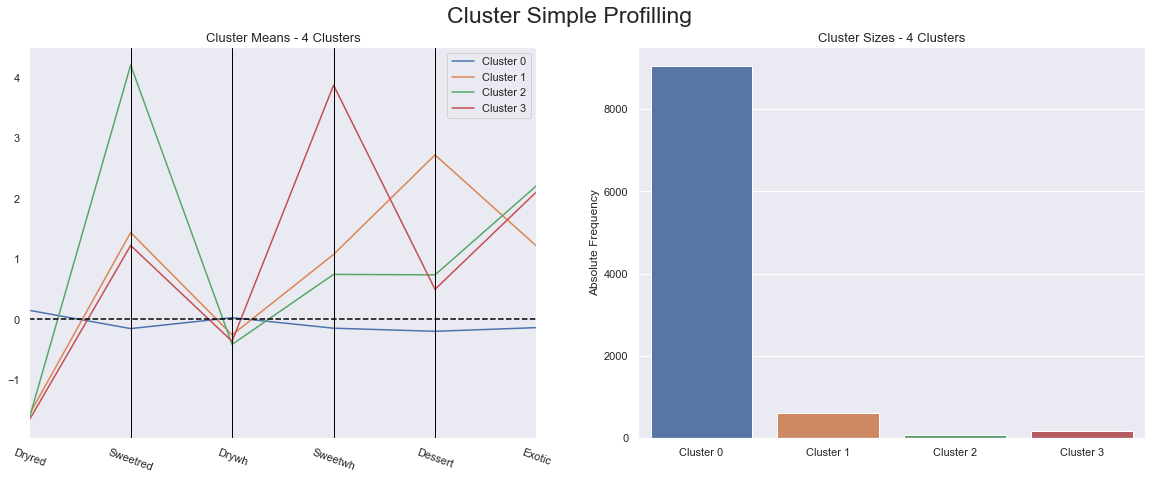

In [119]:
cluster_profiles(df_ms_wp, ['ms_wp_labels'], (20,7))

<hr>
<a class="anchor" id="dbscan">
    
## 6.5 DBSCAN
    
</a>

### Customer Value Perspective

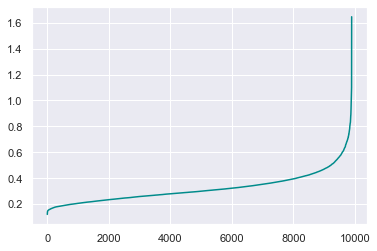

In [120]:
# To create clusters using the D-Bscan, use the same logic defined when
# detecting the outliers
neigh = NearestNeighbors(n_neighbors= 2*len(customer_value)-1)
neigh.fit(www_cv)
distances, _ = neigh.kneighbors(www_cv)
distances = np.sort(distances[:, -1])
plt.plot(distances,color = 'darkcyan')
plt.show()

In [121]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.58, min_samples=2*len(customer_value), n_jobs=4)
dbscan_labels = dbscan.fit_predict(www_cv)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [122]:
Counter(dbscan_labels)

Counter({0: 9796, -1: 101})

In [123]:
df_dbscan_cv = pd.concat([www_cv, pd.Series(dbscan_labels, name='dbscan_labels', index=www_cv.index)], axis=1)

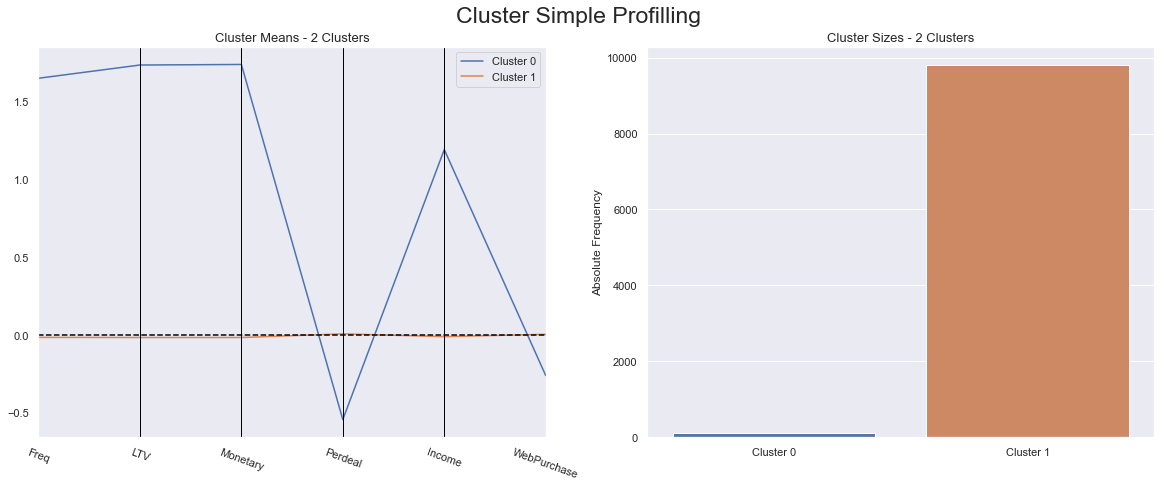

In [124]:
cluster_profiles(df_dbscan_cv, ['dbscan_labels'], (20,7))

### Wine Preferences Perspective

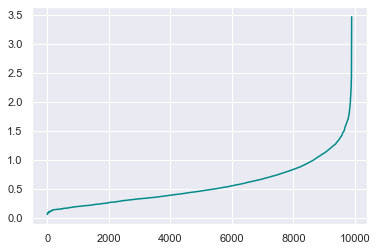

In [125]:
# To create clusters using the D-Bscan, use the same logic defined when
# detecting the outliers
neigh = NearestNeighbors(n_neighbors= 2*len(wine_preferences)-1)
neigh.fit(www_wp)
distances, _ = neigh.kneighbors(www_wp)
distances = np.sort(distances[:, -1])
plt.plot(distances,color = 'darkcyan')
plt.show()

In [126]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.3, min_samples=2*len(wine_preferences), n_jobs=4)
dbscan_labels = dbscan.fit_predict(www_wp)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [127]:
Counter(dbscan_labels)

Counter({0: 9694, -1: 203})

In [128]:
df_dbscan_wp = pd.concat([www_wp, pd.Series(dbscan_labels, name='dbscan_labels', index=www_wp.index)], axis=1)

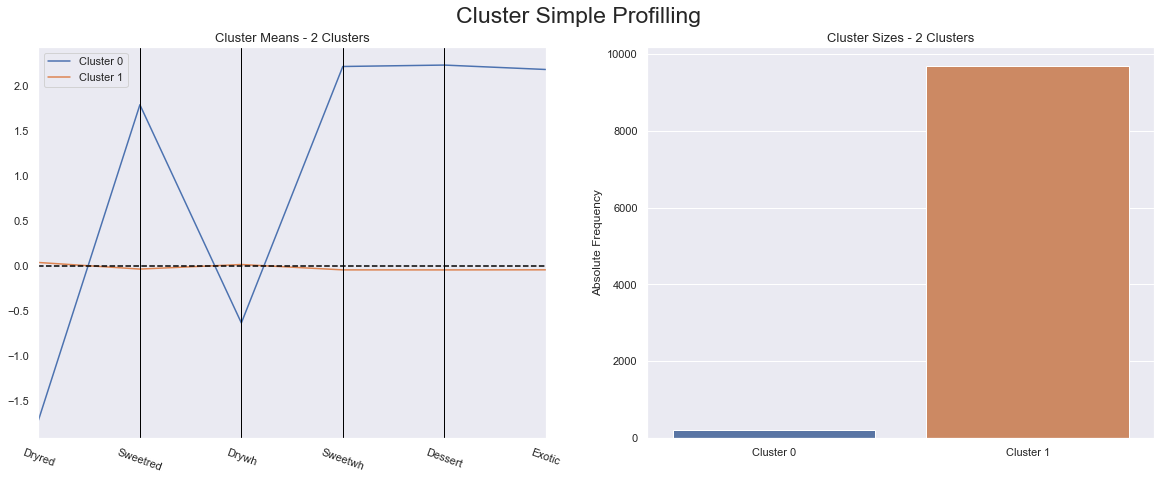

In [129]:
cluster_profiles(df_dbscan_wp, ['dbscan_labels'], (20,7))

<hr>
<a class="anchor" id="birch">
    
## 6.6 BIRCH
    
</a>

### Customer Value Perspective

In [130]:
birch = Birch(branching_factor = 300, n_clusters = 4, threshold = 0.1)
birch_labels = birch.fit_predict(www_cv)

In [131]:
df_birch_cv = pd.concat([www_cv, pd.Series(birch_labels, name='birch_labels', index=www_cv.index)], axis=1)

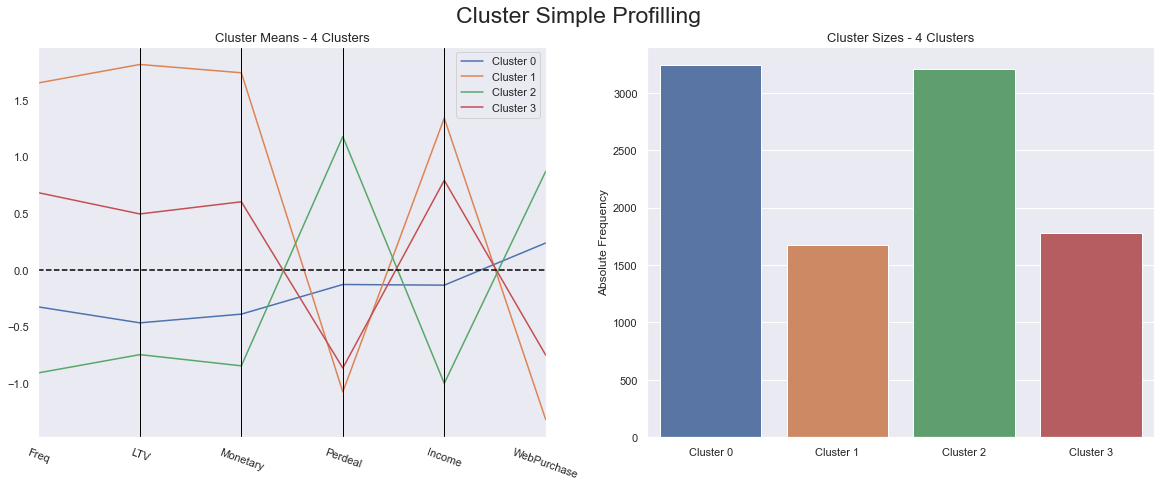

In [132]:
cluster_profiles(df_birch_cv, ['birch_labels'], (20,7))

### Wine Preferences Perspective

In [133]:
birch = Birch(branching_factor = 200, n_clusters = 4, threshold = 0.1)
birch_labels = birch.fit_predict(www_wp)

In [134]:
df_birch_wp = pd.concat([www_wp, pd.Series(birch_labels, name='birch_labels', index=www_wp.index)], axis=1)

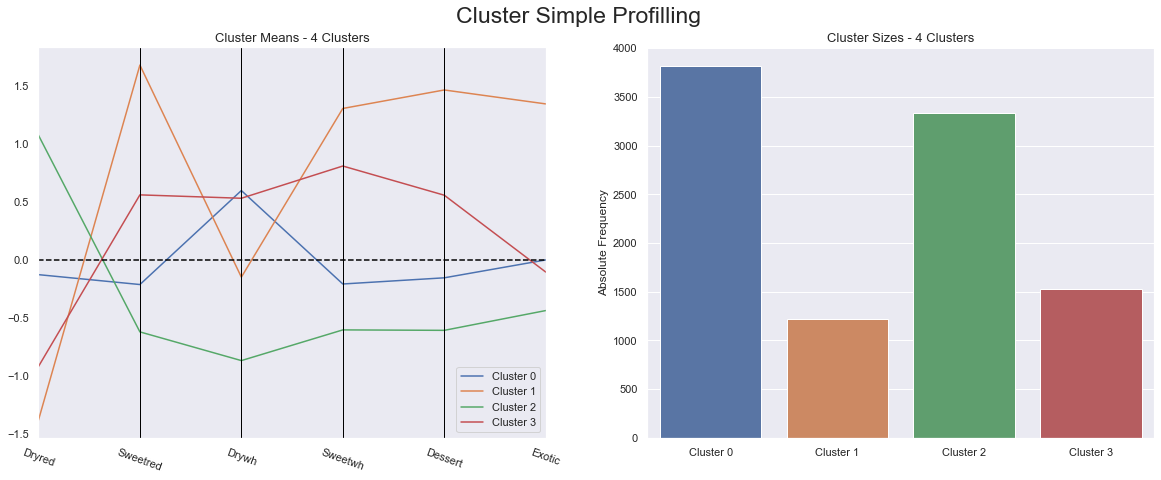

In [135]:
cluster_profiles(df_birch_wp, ['birch_labels'], (20,7))

<hr>
<a class="anchor" id="optics">
    
## 6.7 OPTICS
    
</a>

### Customer Value Perspective

In [136]:
# Perform OPTICS clustering
optics = OPTICS(eps=0.58, min_samples=2*len(customer_value), n_jobs=4)
optics_labels = optics.fit_predict(www_cv)

optics_n_clusters = len(np.unique(optics_labels))
print("Number of estimated clusters : %d" % optics_n_clusters)

Number of estimated clusters : 2


In [137]:
Counter(optics_labels)

Counter({-1: 9880, 0: 17})

In [138]:
df_optics_cv = pd.concat([www_cv, pd.Series(optics_labels, name='optics_labels', index=www_cv.index)], axis=1)

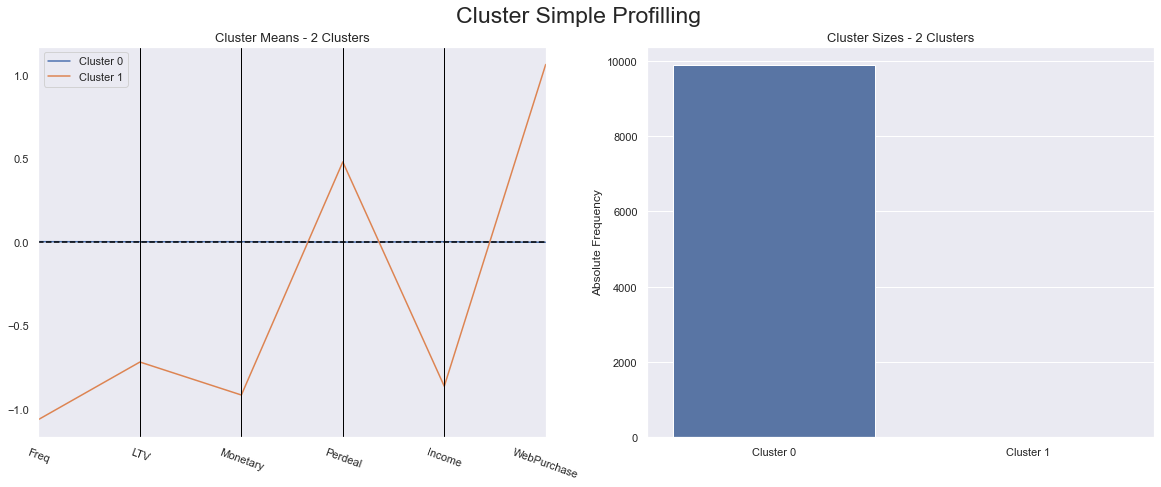

In [139]:
cluster_profiles(df_optics_cv, ['optics_labels'], (20,7))

### Wine Preferences Perspective

In [140]:
# Perform OPTICS clustering
optics = OPTICS(eps=1.3, min_samples=2*len(wine_preferences), n_jobs=4)
optics_labels = optics.fit_predict(www_wp)

optics_n_clusters = len(np.unique(optics_labels))
print("Number of estimated clusters : %d" % optics_n_clusters)

Number of estimated clusters : 5


In [141]:
Counter(optics_labels)

Counter({-1: 9832, 0: 17, 3: 16, 2: 13, 1: 19})

In [142]:
df_optics_wp = pd.concat([www_wp, pd.Series(optics_labels, name='optics_labels', index=www_wp.index)], axis=1)

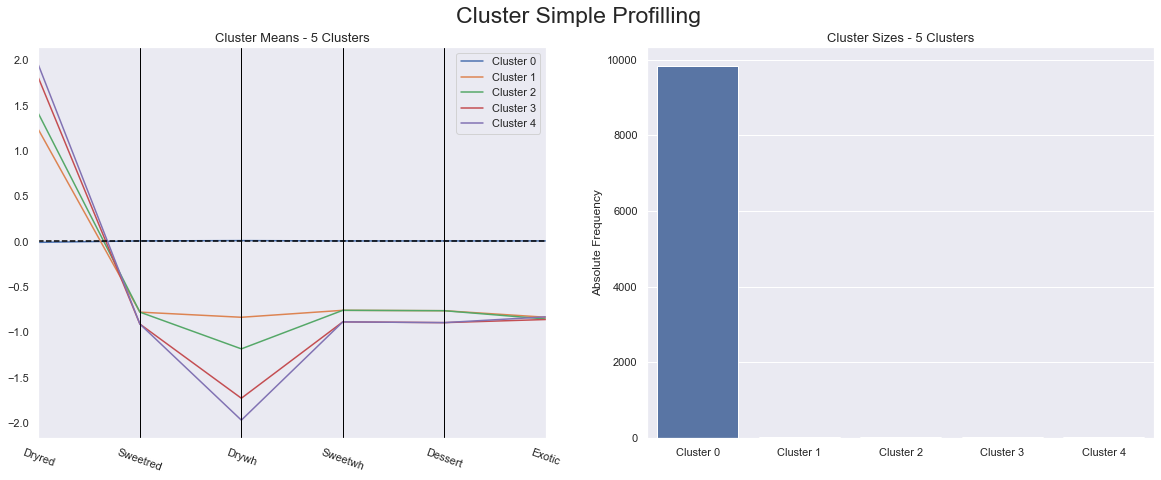

In [143]:
cluster_profiles(df_optics_wp, ['optics_labels'], (20,7))

<hr>
<a class="anchor" id="clustmetcomp">
    
# 7. Clustering Methods Comparison
    
</a>

### Customer Value Perspective

In [144]:
data1 = [['K-Means + Hierarchical', silhouette_score(www_km_cv[customer_value], www_km_cv['kmeans_labels'], metric = 'euclidean'), calinski_harabasz_score(www_km_cv[customer_value], www_km_cv['kmeans_labels']), davies_bouldin_score(www_km_cv[customer_value], www_km_cv['kmeans_labels'])], 
        ['SOM + Hierarchical', silhouette_score(df_somf_cv[customer_value], df_somf_cv['som_h_label'], metric = 'euclidean'), calinski_harabasz_score(df_somf_cv[customer_value], df_somf_cv['som_h_label']), davies_bouldin_score(df_somf_cv[customer_value], df_somf_cv['som_h_label'])], 
        ['SOM + K-means', silhouette_score(df_somf_cv2[customer_value], df_somf_cv2['som_k_label'], metric = 'euclidean'), calinski_harabasz_score(df_somf_cv2[customer_value], df_somf_cv2['som_k_label']), davies_bouldin_score(df_somf_cv2[customer_value], df_somf_cv2['som_k_label'])],
        ['Mean Shift', silhouette_score(df_ms_cv[customer_value], df_ms_cv['ms_cv_labels'], metric = 'euclidean'), calinski_harabasz_score(df_ms_cv[customer_value], df_ms_cv['ms_cv_labels']), davies_bouldin_score(df_ms_cv[customer_value], df_ms_cv['ms_cv_labels'])],
        ['DBSCAN', silhouette_score(df_dbscan_cv[customer_value], df_dbscan_cv['dbscan_labels'], metric = 'euclidean'), calinski_harabasz_score(df_dbscan_cv[customer_value], df_dbscan_cv['dbscan_labels']), davies_bouldin_score(df_dbscan_cv[customer_value], df_dbscan_cv['dbscan_labels'])],
        ['BIRCH', silhouette_score(df_birch_cv[customer_value], df_birch_cv['birch_labels'], metric = 'euclidean'), calinski_harabasz_score(df_birch_cv[customer_value], df_birch_cv['birch_labels']), davies_bouldin_score(df_birch_cv[customer_value], df_birch_cv['birch_labels'])],
        ['OPTICS', silhouette_score(df_optics_cv[customer_value], df_optics_cv['optics_labels'], metric = 'euclidean'), calinski_harabasz_score(df_optics_cv[customer_value], df_optics_cv['optics_labels']), davies_bouldin_score(df_optics_cv[customer_value], df_optics_cv['optics_labels'])]]

In [147]:
comparison_cv =pd.DataFrame(data1, columns = ['Method', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
comparison_cv

Method  Silhouette Score  Calinski-Harabasz Score  \
0  K-Means + Hierarchical          0.233031             10696.687751   
1      SOM + Hierarchical          0.259390             11344.894662   
2           SOM + K-means          0.412197             15582.576470   
3              Mean Shift          0.316253             12766.896662   
4                  DBSCAN          0.296142               181.936113   
5                   BIRCH          0.302936             12575.802632   
6                  OPTICS         -0.185986                13.008689   

   Davies-Bouldin Score  
0              1.288848  
1              1.212045  
2              0.857948  
3              1.101882  
4              1.498232  
5              1.038130  
6              1.096502

##### For this perspective we decided to keep the SOM + K-Means solution.

### Wine Preferences Perspective

In [145]:
data2 = [['K-Means + Hierarchical', silhouette_score(www_km_wp[wine_preferences], www_km_wp['kmeans_labels'], metric = 'euclidean'), calinski_harabasz_score(www_km_wp[wine_preferences], www_km_wp['kmeans_labels']), davies_bouldin_score(www_km_wp[wine_preferences], www_km_wp['kmeans_labels'])], 
        ['SOM + Hierarchical', silhouette_score(df_somf_wp[wine_preferences], df_somf_wp['som_h_label'], metric = 'euclidean'), calinski_harabasz_score(df_somf_wp[wine_preferences], df_somf_wp['som_h_label']), davies_bouldin_score(df_somf_wp[wine_preferences], df_somf_wp['som_h_label'])], 
        ['SOM + K-means', silhouette_score(df_somf_wp2[wine_preferences], df_somf_wp2['som_k_label'], metric = 'euclidean'), calinski_harabasz_score(df_somf_wp2[wine_preferences], df_somf_wp2['som_k_label']), davies_bouldin_score(df_somf_wp2[wine_preferences], df_somf_wp2['som_k_label'])],
        ['Mean Shift', silhouette_score(df_ms_wp[wine_preferences], df_ms_wp['ms_wp_labels'], metric = 'euclidean'), calinski_harabasz_score(df_ms_wp[wine_preferences], df_ms_wp['ms_wp_labels']), davies_bouldin_score(df_ms_wp[wine_preferences], df_ms_wp['ms_wp_labels'])],
        ['DBSCAN', silhouette_score(df_dbscan_wp[wine_preferences], df_dbscan_wp['dbscan_labels'], metric = 'euclidean'), calinski_harabasz_score(df_dbscan_wp[wine_preferences], df_dbscan_wp['dbscan_labels']), davies_bouldin_score(df_dbscan_wp[wine_preferences], df_dbscan_wp['dbscan_labels'])],
        ['BIRCH', silhouette_score(df_birch_wp[wine_preferences], df_birch_wp['birch_labels'], metric = 'euclidean'), calinski_harabasz_score(df_birch_wp[wine_preferences], df_birch_wp['birch_labels']), davies_bouldin_score(df_birch_wp[wine_preferences], df_birch_wp['birch_labels'])],
        ['OPTICS', silhouette_score(df_optics_wp[wine_preferences], df_optics_wp['optics_labels'], metric = 'euclidean'), calinski_harabasz_score(df_optics_wp[wine_preferences], df_optics_wp['optics_labels']), davies_bouldin_score(df_optics_wp[wine_preferences], df_optics_wp['optics_labels'])]]

In [146]:
comparison_wp = pd.DataFrame(data2, columns = ['Method', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
comparison_wp

Method  Silhouette Score  Calinski-Harabasz Score  \
0  K-Means + Hierarchical          0.268888              2893.758156   
1      SOM + Hierarchical          0.234962              3353.304899   
2           SOM + K-means          0.289379              4515.889572   
3              Mean Shift          0.434276              1203.869270   
4                  DBSCAN          0.520977               792.776038   
5                   BIRCH          0.216406              3119.377606   
6                  OPTICS         -0.173022                20.540471   

   Davies-Bouldin Score  
0              1.354313  
1              1.730007  
2              1.344783  
3              1.246985  
4              1.283742  
5              1.851405  
6              0.886619

##### For this perspective we decided to keep the SOM + K-Means solution.

<hr>
<a class="anchor" id="mergpersp">
    
# 8. Merging the Perspectives 
    
</a>

In [147]:
www_standard['customer_value_labels'] = df_somf_cv2['som_k_label']
www_standard['wine_preferences_labels'] = df_somf_wp2['som_k_label']

In [148]:
# Count label frequencies (contigency table)
www_standard.groupby(['customer_value_labels', 'wine_preferences_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('customer_value_labels', 'wine_preferences_labels', 0)

wine_preferences_labels     0     1     2
customer_value_labels                    
0                        1655  1747  1234
1                        1529   786   240
2                         846  1639   221

### Manual merging: Merge lowest frequency clusters into closest clusters

In [149]:
# Clusters with low frequency to be merged:
to_merge = [(1,2), (2,2)]

df_centroids = www_standard.groupby(['customer_value_labels', 'wine_preferences_labels']).mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target  ##remove 1 clusters instead of 2

{(1, 2): (1, 0), (2, 2): (2, 0)}

In [150]:
df_ = www_standard.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['customer_value_labels']==source[0]) & (df_['wine_preferences_labels']==source[1])
    df_.loc[mask, 'customer_value_labels'] = target[0]
    df_.loc[mask, 'wine_preferences_labels'] = target[1]

# New contigency table
df_.groupby(['customer_value_labels', 'wine_preferences_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('customer_value_labels', 'wine_preferences_labels', 0)

wine_preferences_labels       0       1       2
customer_value_labels                          
0                        1655.0  1747.0  1234.0
1                        1769.0   786.0     NaN
2                        1067.0  1639.0     NaN

In [151]:
df_['merged_labels'] = df_.apply(
    lambda row: (row['customer_value_labels'], row['wine_preferences_labels'])
    , axis=1
)

df_.groupby('merged_labels').mean()

Income      Freq  Monetary       LTV   Perdeal    Dryred  \
merged_labels                                                               
(0.0, 0.0)    -0.886107 -0.863089 -0.812342 -0.725278  0.885794 -0.455321   
(0.0, 1.0)    -0.517012 -0.765348 -0.740146 -0.733310  0.869805  0.949849   
(0.0, 2.0)    -1.320597 -0.927638 -0.865951 -0.721786  0.864837 -1.444182   
(1.0, 0.0)     1.250949  1.403060  1.447903  1.482357 -1.061527 -0.584428   
(1.0, 1.0)     1.113984  1.374256  1.413544  1.372369 -0.979859  0.783050   
(2.0, 0.0)     0.386084  0.083224 -0.034477 -0.122920 -0.585622 -0.432188   
(2.0, 1.0)     0.304375  0.158146  0.042981 -0.120625 -0.475826  1.071270   

               Sweetred     Drywh   Sweetwh   Dessert    Exotic  WebPurchase  \
merged_labels                                                                  
(0.0, 0.0)    -0.037346  0.888946 -0.021808 -0.010527  0.163018     0.814771   
(0.0, 1.0)    -0.596966 -0.679418 -0.574840 -0.600310  0.014749     0.628433   
(0.0, 2.0)     1.448754 -0.002597  1.441235  1.493484  1.371297     0.792032   
(1.0, 0.0)     0.174971  0.798346  0.149585  0.143401 -0.481499    -1.345987   
(1.0, 1.0)    -0.519405 -0.515449 -0.497989 -0.513898 -0.595915    -0.841780   
(2.0, 0.0)     0.327570  0.225642  0.304847  0.312441 -0.153680    -0.469131   
(2.0, 1.0)    -0.569764 -0.932854 -0.571455 -0.585676 -0.307263     0.072951   

               customer_value_labels  wine_preferences_labels  
merged_labels                                                  
(0.0, 0.0)                         0                        0  
(0.0, 1.0)                         0                        1  
(0.0, 2.0)                         0                        2  
(1.0, 0.0)                         1                        0  
(1.0, 1.0)                         1                        1  
(2.0, 0.0)                         2                        0  
(2.0, 1.0)                         2                        1

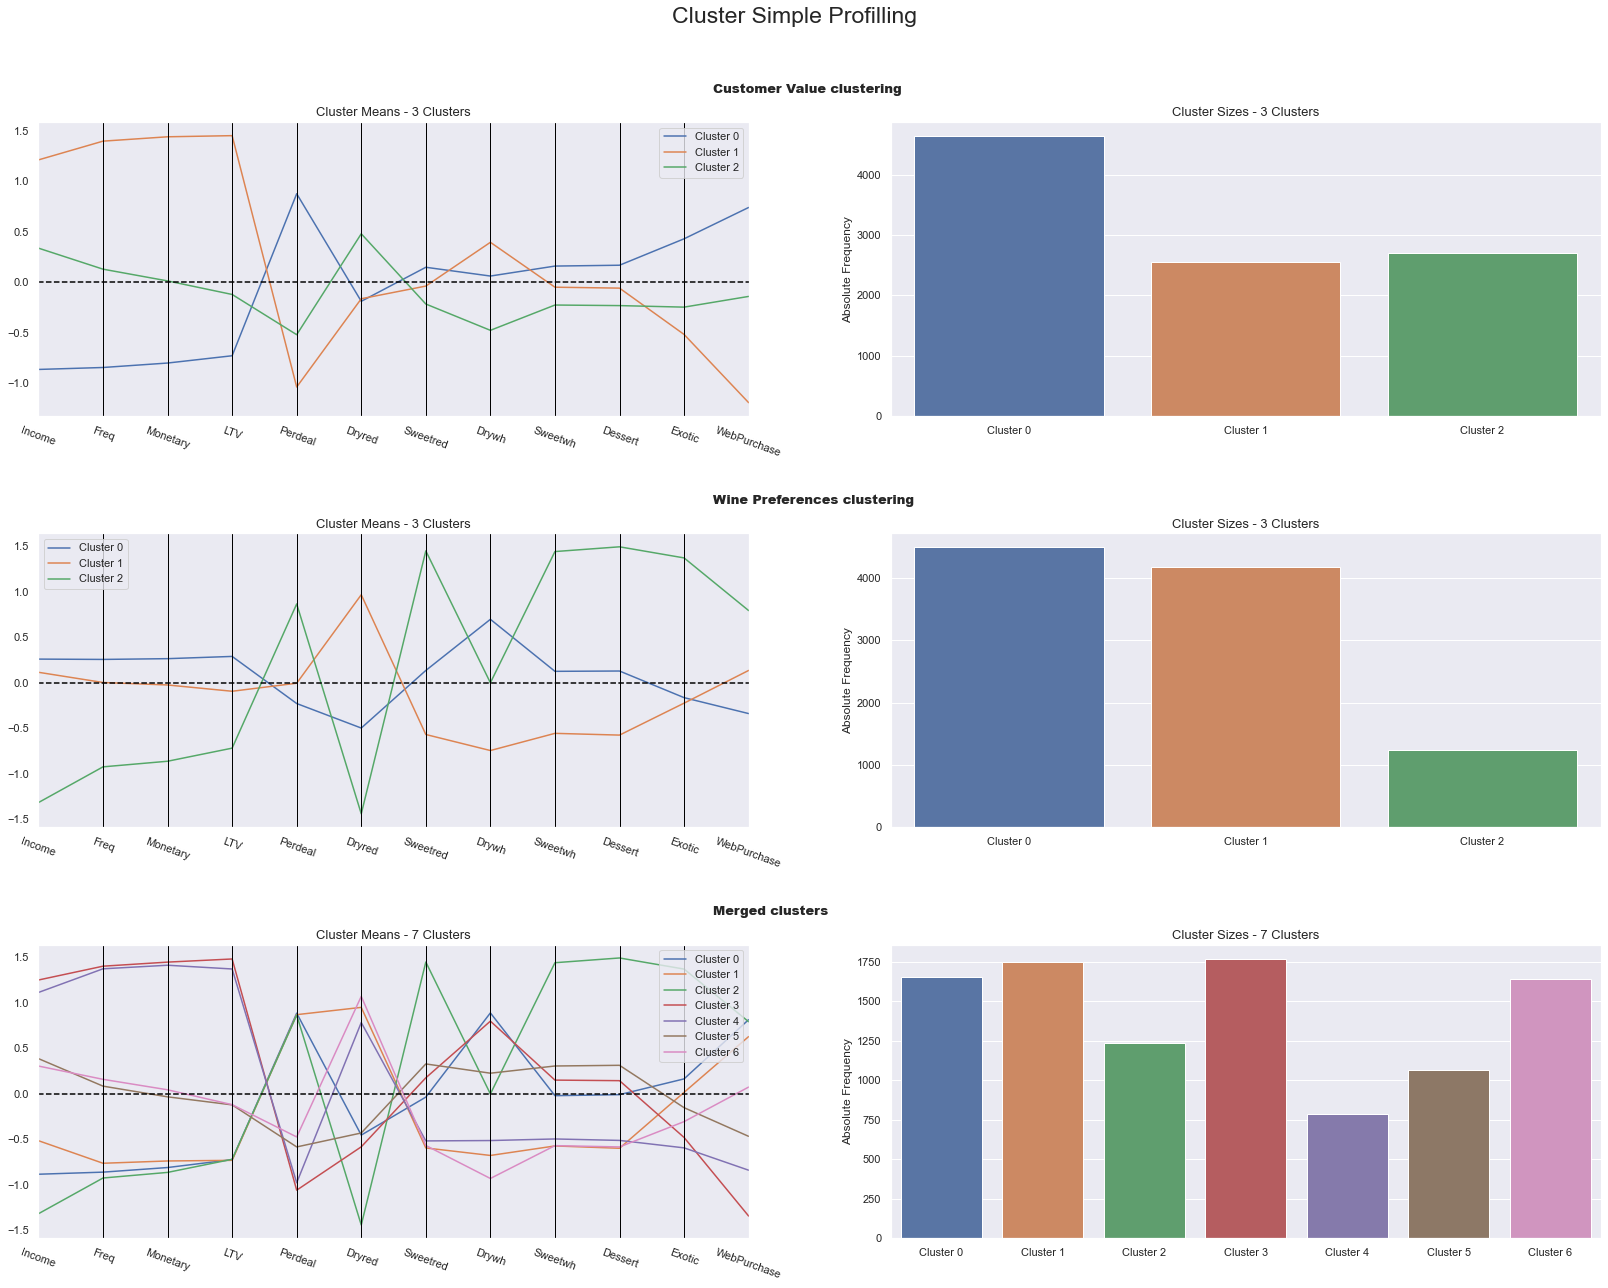

In [152]:
# Profilling each cluster (personal, premiums, dem/financial, merged)
cluster_profiles(
    df = df_, 
    label_columns = ['customer_value_labels', 'wine_preferences_labels', 'merged_labels'], 
    figsize = (28, 20), 
    compar_titles = ["Customer Value clustering","Wine Preferences clustering", "Merged clusters"]
)

<hr>
<a class="anchor" id="t-sne">
    
# 9. Cluster visualization using t-SNE
    
</a>

In [153]:
df_['merged_labels'][df_['merged_labels'] == (0.0, 0.0)] = 0
df_['merged_labels'][df_['merged_labels'] == (0.0, 1.0)] = 1
df_['merged_labels'][df_['merged_labels'] == (0.0, 2.0)] = 2
df_['merged_labels'][df_['merged_labels'] == (1.0, 0.0)] = 3
df_['merged_labels'][df_['merged_labels'] == (1.0, 1.0)] = 4
df_['merged_labels'][df_['merged_labels'] == (2.0, 0.0)] = 5
df_['merged_labels'][df_['merged_labels'] == (2.0, 1.0)] = 6

In [154]:
Counter(df_['merged_labels'])

Counter({6: 1639, 3: 1769, 2: 1234, 1: 1747, 0: 1655, 5: 1067, 4: 786})

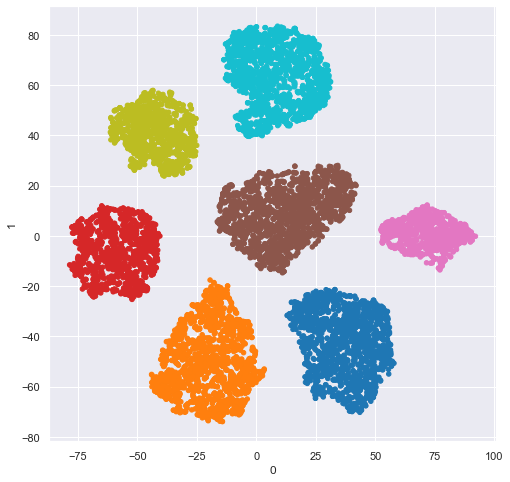

In [155]:
# Apply t-SNE to get a more realistic visualization of our clusters
two_dim = TSNE(random_state=93).fit_transform(df_)


pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_['merged_labels'], colormap='tab10', figsize=(8,8))
plt.show()

<hr>
<a class="anchor" id="featimp">
    
# 10. Assess feature importance
    
</a>

In [156]:
# Finally and in order to classify the previous outliers, it´s important to get the
# r squared of each variable (which reflect it importance), and the use algorithms
# such as Decision Trees or K-Nearest Neighbours to classify them
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [157]:
# Get R² for each variable
r2_variables(df_[(customer_value + wine_preferences) + ['merged_labels']], 'merged_labels').drop('merged_labels').sort_values(ascending = False)

Freq           0.841998
Monetary       0.834383
Income         0.805605
LTV            0.794219
Dryred         0.773910
Perdeal        0.710143
WebPurchase    0.663645
Drywh          0.498251
Dessert        0.433717
Sweetred       0.417064
Sweetwh        0.405191
Exotic         0.326769
dtype: float64

In [158]:
df_['merged_labels'] = df_['merged_labels'].astype('int64')

<hr>
<a class="anchor" id="reoutliers">
    
# 11. Reclassify outliers
    
</a>

In [159]:
# Preparing the data
X = df_.drop(columns=['customer_value_labels','wine_preferences_labels','merged_labels'])
y = df_['merged_labels'].astype('int64')

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=93, stratify=y
)

### Logistic Regression

In [160]:
lr = LogisticRegression(random_state=93)
lr.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(lr.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 93.94% of the customers correctly


In [161]:
# reclassify outliers

www_out['merged_labels'] = lr.predict(www_out_standard)
www_out.head()

Income  Freq  Monetary  LTV  Perdeal  Dryred  Sweetred  Drywh  \
Custid                                                                   
4324    28393.0   1.0      13.0 -1.0     62.0     7.0      50.0    8.0   
3142    45638.0   1.0      19.0 -5.0     78.0    38.0      10.0   35.0   
3950    39572.0   1.0      11.0 -6.0     93.0    11.0      16.0   11.0   
3012    36031.0   1.0      14.0  0.0     44.0    12.0       3.0   48.0   
5642    29660.0   1.0      14.0  1.0     39.0    11.0      14.0   12.0   

        Sweetwh  Dessert  Exotic  WebPurchase  merged_labels  
Custid                                                        
4324       34.0      0.0    48.0         44.0              2  
3142        7.0     10.0    63.0         33.0              2  
3950       61.0      2.0    91.0         39.0              2  
3012       31.0      6.0    62.0         62.0              2  
5642       35.0     28.0    68.0         37.0              2

In [162]:
www_out['merged_labels'].value_counts()

2    75
0    12
5     4
1     2
3     1
Name: merged_labels, dtype: int64

### Decision Trees

In [163]:
# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=93, max_depth=4)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 86.13% of the customers correctly


### KNN

In [164]:
kn = KNeighborsClassifier(n_neighbors = 19)
kn.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(kn.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 93.77% of the customers correctly


<hr>
<a class="anchor" id="finalanalysis">
    
# 12. Final Clustering Analysis
    
</a>

In [165]:
www['customer_value_labels'] = df_['customer_value_labels']
www['wine_preferences_labels'] = df_['wine_preferences_labels']
www['merged_labels'] = df_['merged_labels']

In [166]:
www

Income  Freq  Monetary    LTV  Perdeal  Dryred  Sweetred  Drywh  \
Custid                                                                      
5325     78473.0  20.0     826.0  445.0      7.0    67.0       4.0   26.0   
3956    105087.0  36.0    1852.0  539.0      2.0    49.0       0.0   46.0   
3681     27984.0   4.0      39.0   -7.0     88.0     4.0      29.0   14.0   
2829     61748.0   2.0      37.0   -6.0     70.0    86.0       1.0   11.0   
8788     65789.0   2.0      36.0    4.0     35.0    85.0       0.0   12.0   
...          ...   ...       ...    ...      ...     ...       ...    ...   
1383     81033.0  19.0     776.0  187.0     22.0    78.0       0.0   20.0   
4070     84714.0  18.0     720.0  391.0      5.0    30.0      12.0   36.0   
7909     40466.0   3.0      47.0    5.0     23.0     6.0      24.0   10.0   
4158     53661.0   1.0      15.0    2.0     35.0    18.0      13.0   45.0   
4914     94926.0  25.0    1148.0  293.0      7.0    63.0      10.0   13.0   

        Sweetwh  Dessert  Exotic  WebPurchase  customer_value_labels  \
Custid                                                                 
5325        2.0      1.0     1.0         36.0                      2   
3956        1.0      3.0     0.0         20.0                      1   
3681       32.0     21.0    48.0         60.0                      0   
2829        1.0      1.0    55.0         59.0                      0   
8788        2.0      1.0    28.0         63.0                      0   
...         ...      ...     ...          ...                    ...   
1383        1.0      1.0    11.0         27.0                      2   
4070       10.0     12.0    13.0         18.0                      2   
7909       38.0     22.0    41.0         58.0                      0   
4158       11.0     13.0    13.0         60.0                      0   
4914       11.0      3.0     4.0         34.0                      1   

        wine_preferences_labels  merged_labels  
Custid                                          
5325                          1              6  
3956                          0              3  
3681                          2              2  
2829                          1              1  
8788                          1              1  
...                         ...            ...  
1383                          1              6  
4070                          0              5  
7909                          2              2  
4158                          0              0  
4914                          1              4  

[9897 rows x 15 columns]

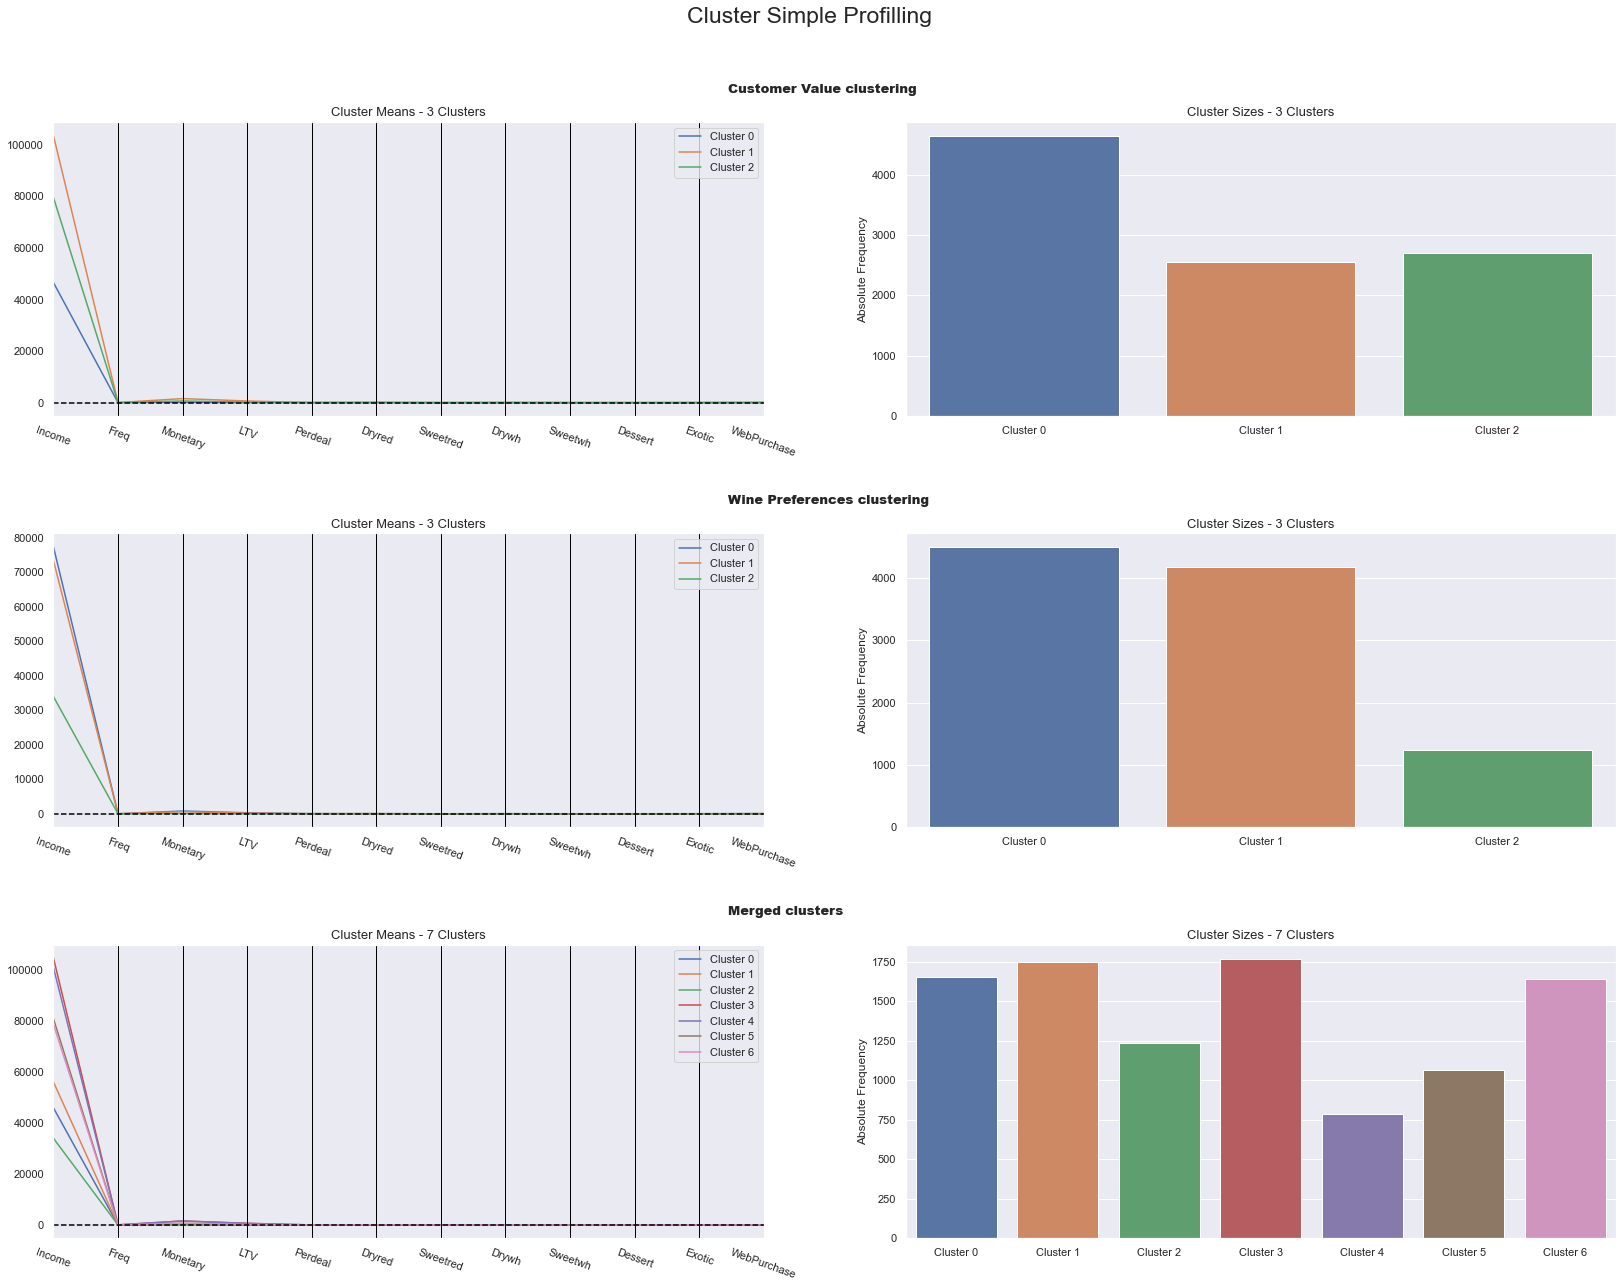

In [167]:
# Profilling each cluster (personal, premiums, dem/financial, merged)
cluster_profiles(
    df = www, 
    label_columns = ['customer_value_labels', 'wine_preferences_labels', 'merged_labels'], 
    figsize = (28, 20), 
    compar_titles = ["Customer Value clustering","Wine Preferences clustering", "Merged clusters"]
)

(<a list of 24 Line2D ticklines objects>,
 [Text(0.0, 0, 'Income'),
  Text(0.5235987755982988, 0, 'Freq'),
  Text(1.0471975511965976, 0, 'Monetary'),
  Text(1.5707963267948966, 0, 'LTV'),
  Text(2.0943951023931953, 0, 'Perdeal'),
  Text(2.617993877991494, 0, 'Dryred'),
  Text(3.141592653589793, 0, 'Sweetred'),
  Text(3.6651914291880923, 0, 'Drywh'),
  Text(4.1887902047863905, 0, 'Sweetwh'),
  Text(4.71238898038469, 0, 'Dessert'),
  Text(5.235987755982988, 0, 'Exotic'),
  Text(5.759586531581287, 0, 'WebPurchase')])

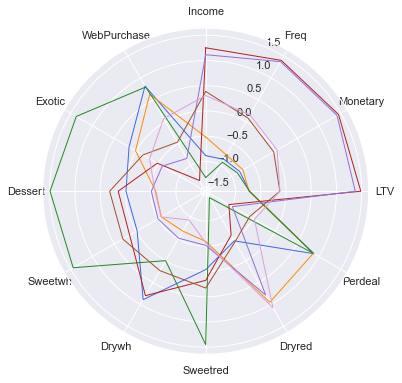

In [168]:
# Each attribute we'll plot in the radar chart.
labels=df_.drop(['wine_preferences_labels','customer_value_labels','merged_labels'],axis=1).columns.tolist()

# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(label, color):
    values = df_.drop(['wine_preferences_labels','customer_value_labels','merged_labels'],axis=1)[df_.drop(['wine_preferences_labels','customer_value_labels'],axis=1)['merged_labels'] == label].mean().values.tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=1, label='Cluster {}'.format(label))
    #ax.fill(angles, values, color=color, alpha=0.25)

# Add each car to the chart.
add_to_radar(0, 'royalblue')
add_to_radar(1, 'darkorange')
add_to_radar(2, 'forestgreen')
add_to_radar(3, 'firebrick')
add_to_radar(4, 'mediumpurple')
add_to_radar(5, 'sienna')
add_to_radar(6, 'plum')

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles)[:-1], labels)